# Trabalho A2 - Análise de Séries Temporais

## Instruções do Trabalho

Utilize o conjunto de dados `data_updated.csv` disponibilizado no e-class. O arquivo contém as variáveis `week`, `volume`, `inv` e `users`. Seu objetivo é modelar a variável `volume` utilizando os conceitos aprendidos em sala de aula.


### Integrantes
- Guilherme Carvalho
- Guilherme Buss
- Gustavo Bianchi
- João Gabriel
- Luís Felipe Marciano
- Vinícius Nascimento

### Objetivos
- Carregar e analisar data.csv
- Implementar baselines (mean, naive, seasonal naive, drift)
- Testar transformações (Box-Cox / log)
- Decompor série em tendência e sazonalidade
- Criar covariáveis (tempo, dummies sazonais, sen/cos, lags, rollings)
- Ajustar modelos de regressão linear múltipla
- Diagnosticar resíduos (ACF, Ljung-Box)
- Comparar usando métricas: MAE, RMSE, MAPE, MASE

---

## **Importação das bibliotecas**

In [15]:
# básicos
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# para modelos 
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# para decomposição e testes
import statsmodels.api as sm
from statsmodels.tsa.seasonal import STL
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import acf, pacf, adfuller

---

## **Pré-visualização dos dados**

In [16]:
df = pd.read_csv("data_updated.csv")

df['week'] = pd.to_datetime(df['week']) # converter week para datetime
df = df.sort_values('week').reset_index(drop=True) # ordenar por data e reset index
df = df.set_index('week')

# checar informações
print('Tamanho da série:', len(df))
print(df.head(10))

Tamanho da série: 157
            volume       inv   users
week                                
2022-10-31    0.38  1.609882   6.500
2022-11-07    0.47  1.880548   7.061
2022-11-14    0.32  2.297810   5.875
2022-11-21    1.69  5.623875  24.238
2022-11-28    1.23  1.473418   7.648
2022-12-05    0.77  0.691911   4.105
2022-12-12    0.49  0.335866   2.060
2022-12-19    0.14  0.182806   0.655
2022-12-26    0.39  0.182695   0.778
2023-01-02    0.33  0.121898   0.808


---

## **Análise inicial dos dados de `volume`**

Antes de iniciar a modelagem, realizamos uma análise descritiva da variável `volume` para compreender sua forma e dispersão de suas amostras.

#### **Centralidade**

* *Média:* O valor médio de `volume` ao longo de todo o período. 
* *Mediana:* O valor que divide a série em duas metades, mais robusta a outliers.

#### **Dispersão**

* *Desvio Padrão:* Grau de dispersão médio dos dados em relação à média.
* *Variância:* É o quadrado do desvio padrão. 

#### **Forma da Distribuição**

* *Assimetria (Skewness):* Mede a falta de simetria da distribuição.
    * `~ 0`: Distribuição aproximadamente simétrica.
    * `> 0`: Assimetria positiva (à direita). A cauda direita da distribuição é mais longa, e a média tende a ser maior que a mediana.
    * `< 0`: Assimetria negativa (à esquerda). A cauda esquerda é mais longa, e a média tende a ser menor que a mediana.

#### **Valores Extremos**

* *Mínimo e Máximo:* Os menores e maiores valores de `volume` observados na série. Ajudam a entender a amplitude total dos dados.

In [17]:
# Métricas iniciais
mean = np.mean(df["volume"])
median = np.median(df["volume"])

std = np.std(df["volume"])
variance = np.var(df["volume"])

skewness = stats.skew(df["volume"])

max_df = np.max(df["volume"])
min_df = np.min(df["volume"])
range_df = max_df - min_df

In [18]:
print("- VARIÁVEL VOLUME - " * 5)
print("-" * 100)

print("--- Tendência Central ---")
print(f"{'Média:':<25} {mean:,.2f}")
print(f"{'Mediana:':<25} {median:,.2f}")

print("\n--- Dispersão ---")
print(f"{'Desvio Padrão:':<25} {std:,.2f}")
print(f"{'Variância:':<25} {variance:,.2f}")

print("\n--- Forma da Distribuição ---")
print(f"{'Assimetria (Skewness):':<25} {skewness:.2f}")

print("\n--- Valores Extremos ---")
print(f"{'Valor Mínimo:':<25} {min_df:,.2f}")
print(f"{'Valor Máximo:':<25} {max_df:,.2f}")
print(f"{'Amplitude (Range):':<25} {range_df:,.2f}")

print("-" * 100)

- VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - - VARIÁVEL VOLUME - 
----------------------------------------------------------------------------------------------------
--- Tendência Central ---
Média:                    4.82
Mediana:                  3.25

--- Dispersão ---
Desvio Padrão:            5.15
Variância:                26.48

--- Forma da Distribuição ---
Assimetria (Skewness):    1.46

--- Valores Extremos ---
Valor Mínimo:             0.14
Valor Máximo:             24.52
Amplitude (Range):        24.38
----------------------------------------------------------------------------------------------------


A análise nos mostra que a série de volume não é 'bem comportada'. Ela tem uma forte assimetria positiva e alta volatilidade. Futuramente, veremos através do gráfico que o grande causador disso seria reflexo da presença de picos em valores elevados. Essa observação que fizemos sugere a possível necessidade de uma transformação de variável (como a logarítmica) antes da modelagem, o que pode estabilizar a variância e tornar a distribuição mais simétrica, o que tende a melhorar o ajuste e o poder preditivo de modelos de regressão.

---

## **Análise da relação entre as variáveis**

Vale também observar como se dá a relação das variáveis entre si

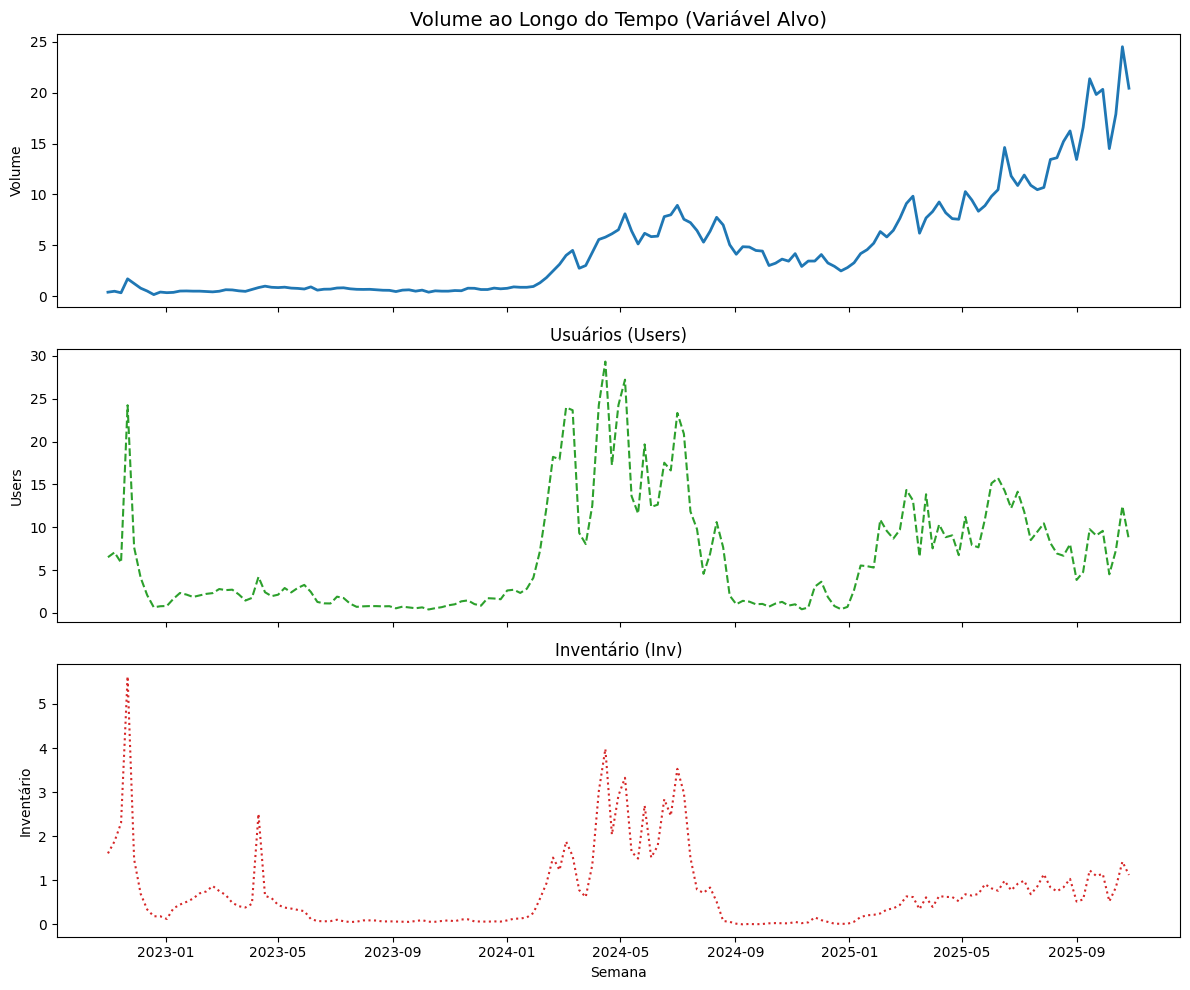

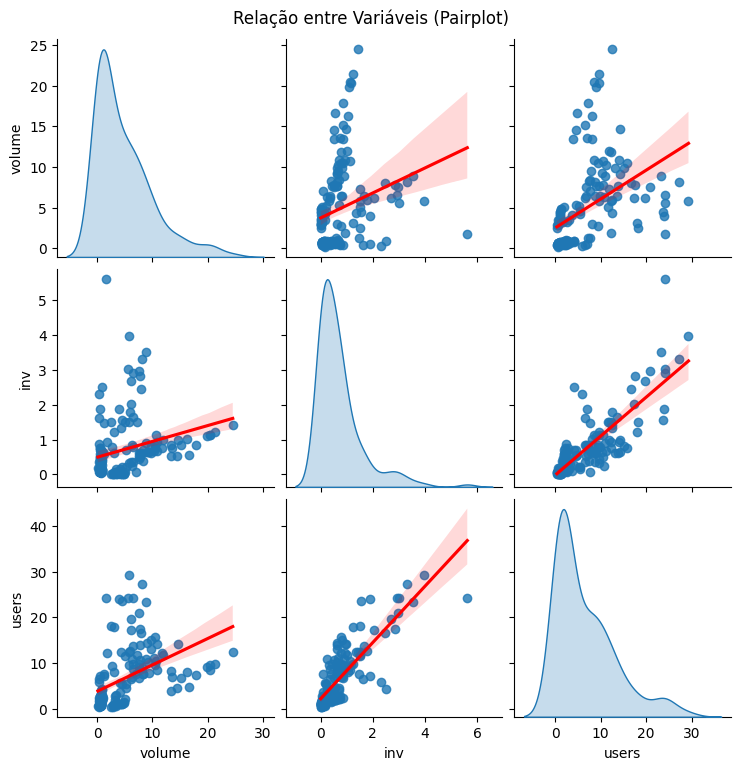

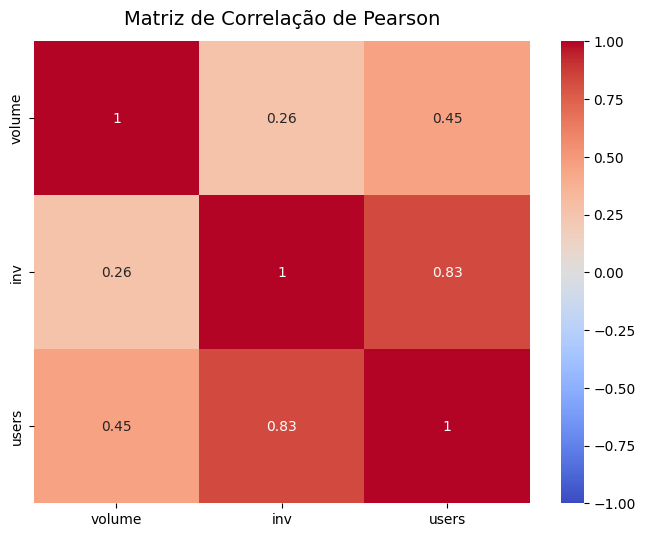

In [19]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 10))

# Plot Volume (Target)
axes[0].plot(df.index, df['volume'], color='tab:blue', linewidth=2)
axes[0].set_title('Volume ao Longo do Tempo (Variável Alvo)', fontsize=14)
axes[0].set_ylabel('Volume')

# Plot Users
axes[1].plot(df.index, df['users'], color='tab:green', linestyle='--')
axes[1].set_title('Usuários (Users)', fontsize=12)
axes[1].set_ylabel('Users')

# Plot Inv
axes[2].plot(df.index, df['inv'], color='tab:red', linestyle=':')
axes[2].set_title('Inventário (Inv)', fontsize=12)
axes[2].set_ylabel('Inventário')
axes[2].set_xlabel('Semana')

plt.tight_layout()
plt.show()

# PAIRPLOT
sns.pairplot(df, kind='reg', diag_kind='kde', plot_kws={'line_kws':{'color':'red'}})
plt.suptitle("Relação entre Variáveis (Pairplot)", y=1.02)
plt.show()

# MATRIZ DE CORRELAÇÃO
plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(df.corr(), annot=True, cmap='coolwarm', vmin=-1, vmax=1)
heatmap.set_title('Matriz de Correlação de Pearson', fontdict={'fontsize':14}, pad=12)
plt.show()

Pôde ser observada uma forte relação linear entre as variáveis preditoras, `inv` e `users`. Mais para frente isso deve ser considerado para a elaboração dos modelos.



---

## **Análise de *Estacionariedade* da série temporal**

A estacionariedade é uma premissa fundamental para muitos modelos de séries temporais. Uma série é dita estacionária se suas propriedades estatísticas, como média e variância, são constantes ao longo do tempo. Nesta seção, investigamos se a série de `volume` atende a essa premissa através de análise visual e Função de Autocorrelação (ACF).

### **Inspeção Visual**

Verificaremos através de visualizações se a série é ou não estacionária:

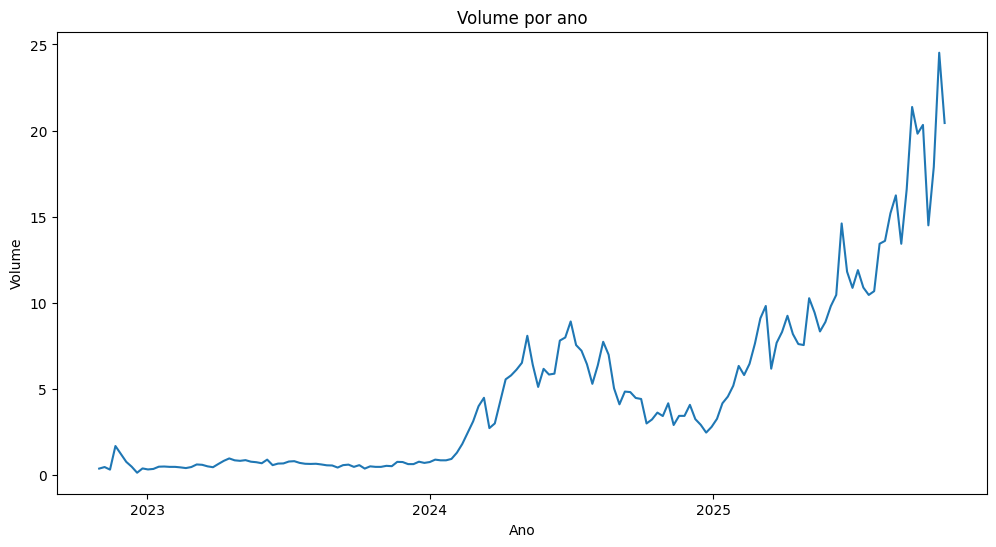

In [20]:
plt.figure(figsize=(12,6))
plt.plot(df.index, df['volume'])

# mostrar apenas os anos
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Volume")
plt.title("Volume por ano")
plt.show()

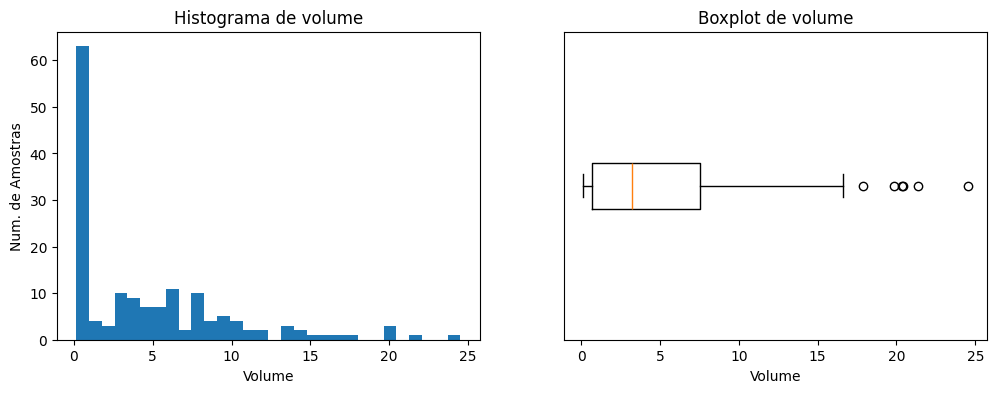

In [21]:
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.hist(df['volume'].dropna(), bins=30)
plt.title('Histograma de volume')
plt.xlabel("Volume")
plt.ylabel("Num. de Amostras")

plt.subplot(1,2,2)
plt.boxplot(df['volume'].dropna(), vert=False)
plt.title('Boxplot de volume')
plt.yticks([])
plt.xlabel("Volume")
plt.show()

Os gráficos sugerem fortemente que a série é não-estacionária, já que:
1.  *Há tendência de crescimento:* Temos uma tendência de alta no `volume` ao longo do período analisado, indicando que a média da série não é constante.
2.  *Variância inconstante:* As oscilações do `volume` aumentam conforme o nível da série sobe, com vales e picos mais distantes.

### **Análise da Série Diferenciada**

Dado que a análise inicial indicou que a série `volume` não é estacionária — possivelmente devido a uma tendência ou variações na média ao longo do tempo —, aplicamos a técnica de diferenciação. Este processo visa estabilizar a média da série, tornando-a estacionária.

O objetivo agora é avaliar se a diferenciação foi bem-sucedida. Para isso, realizaremos novamente a inspeção visual e a análise da Função de Autocorrelação (ACF) na série transformada. Esperamos observar que a série diferenciada não exiba mais tendências claras e que sua autocorrelação decaia rapidamente para zero.

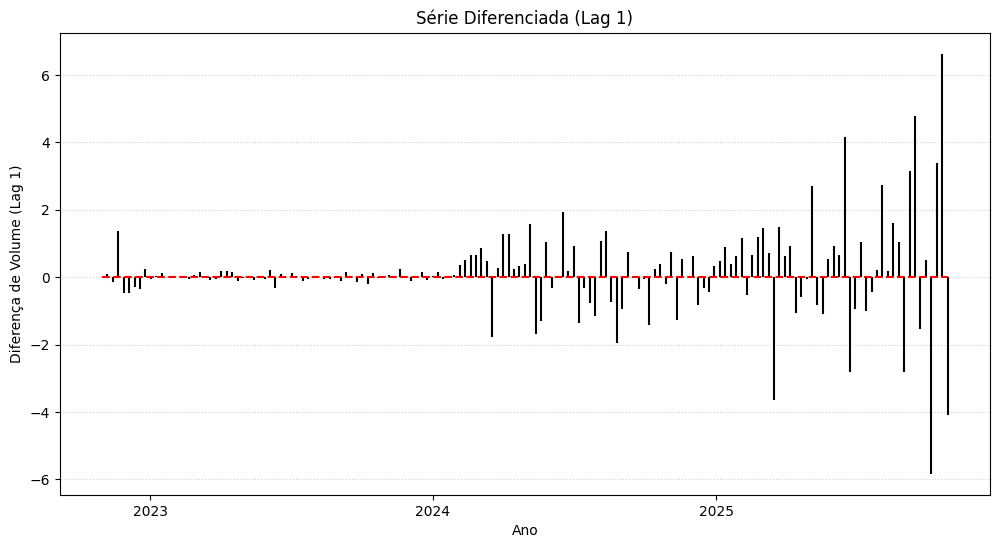

In [22]:
# Diferenciação (Lag 1)
df['volume_diff'] = np.where(df['volume'].diff(1) != np.nan, df['volume'].diff(1), 0)

plt.figure(figsize=(12, 6))

(markers, stemlines, baseline) = plt.stem(
    df.index,
    df['volume_diff'],
    linefmt="k-",    
    markerfmt=" ",   
    basefmt="r--"    
)

plt.setp(stemlines, linewidth=1.5) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Diferença de Volume (Lag 1)")
plt.title("Série Diferenciada (Lag 1)")
plt.grid(axis='y', linestyle=':', alpha=0.6) # Grade apenas no eixo Y
plt.show()

A série diferenciada (Lag 1) mostra que os valores ainda apresentam flutuações grandes ao longo do tempo, com oscilações que parecem se intensificar nos períodos mais recentes. Apesar da diferenciação, não há uma estabilização em torno da linha zero, o que indica que a série ainda pode carregar estruturas de dependência temporal não removidas apenas pela primeira diferenciação.

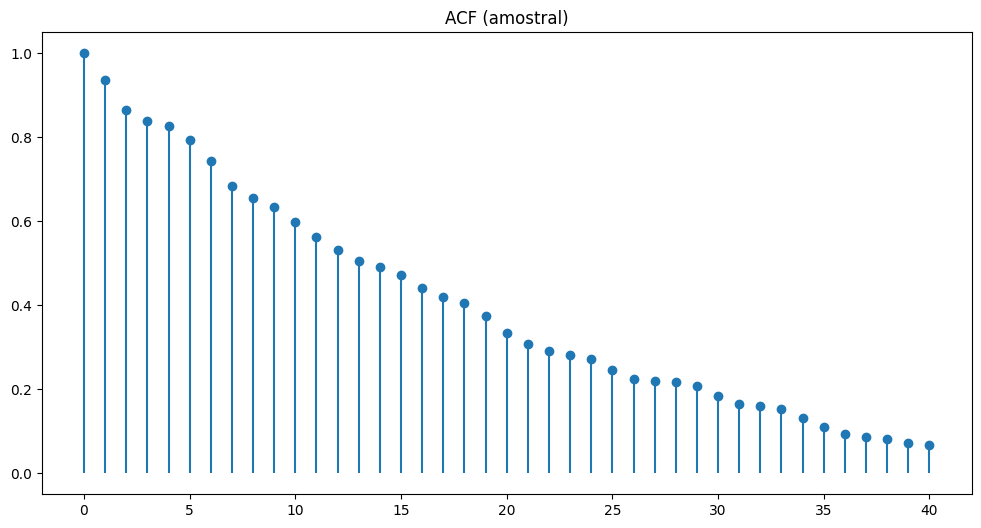

In [23]:
lag_acf = acf(df['volume'].dropna(), nlags=40, fft=False)
plt.figure(figsize=(12,6))
plt.stem(range(len(lag_acf)), lag_acf, basefmt=' ')
plt.title('ACF (amostral)')
plt.show()

Reforçando essa interpretação, o gráfico da ACF exibe uma decadência lenta e gradual das autocorrelações ao longo das defasagens, o que é característica de séries com forte dependência e possível não estacionariedade.

Dessa forma, pode ser necessária a aplicação de mais diferenciações ou transformações adicionais para garantir a estacionariedade antes da modelagem (por exemplo, em ARIMA).

### **Usando Log-Transformação: Será?**

O logaritmo estabiliza a variância, fazendo com que a série se comporte de forma mais homogênea e facilitando a modelagem, especialmente em séries com tendência de crescimento exponencial. Como nossa série tem crescimento aparentemente exponencial, podemos fazer um teste de resíduo após a mudança e observar se vale a pena utilizar uma log-transformação.

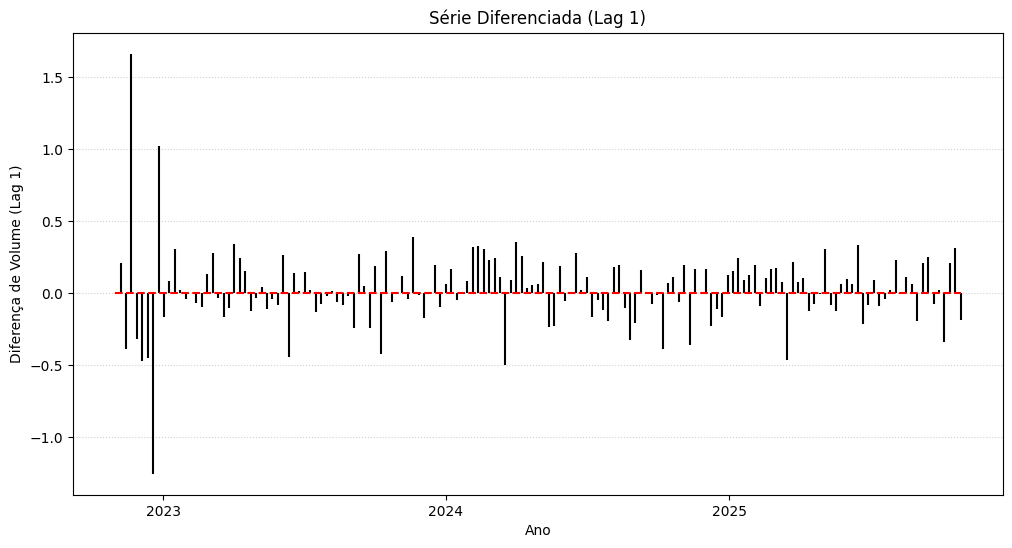

In [24]:
df['volume_log'] = np.log(df['volume']) 
df['volume_log_diff'] = np.where(df['volume_log'].diff(1) != np.nan, df['volume_log'].diff(1), 0)

#print(df.head())
plt.figure(figsize=(12, 6))
(markers, stemlines, baseline) = plt.stem(
    df.index,
    df['volume_log_diff'],
    linefmt="k-",    
    markerfmt=" ",   
    basefmt="r--"    
)

plt.setp(stemlines, linewidth=1.5) 
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.gca().xaxis.set_major_locator(mdates.YearLocator())

plt.xlabel("Ano")
plt.ylabel("Diferença de Volume (Lag 1)")
plt.title("Série Diferenciada (Lag 1)")
plt.grid(axis='y', linestyle=':', alpha=0.6) # Grade apenas no eixo Y
plt.show()

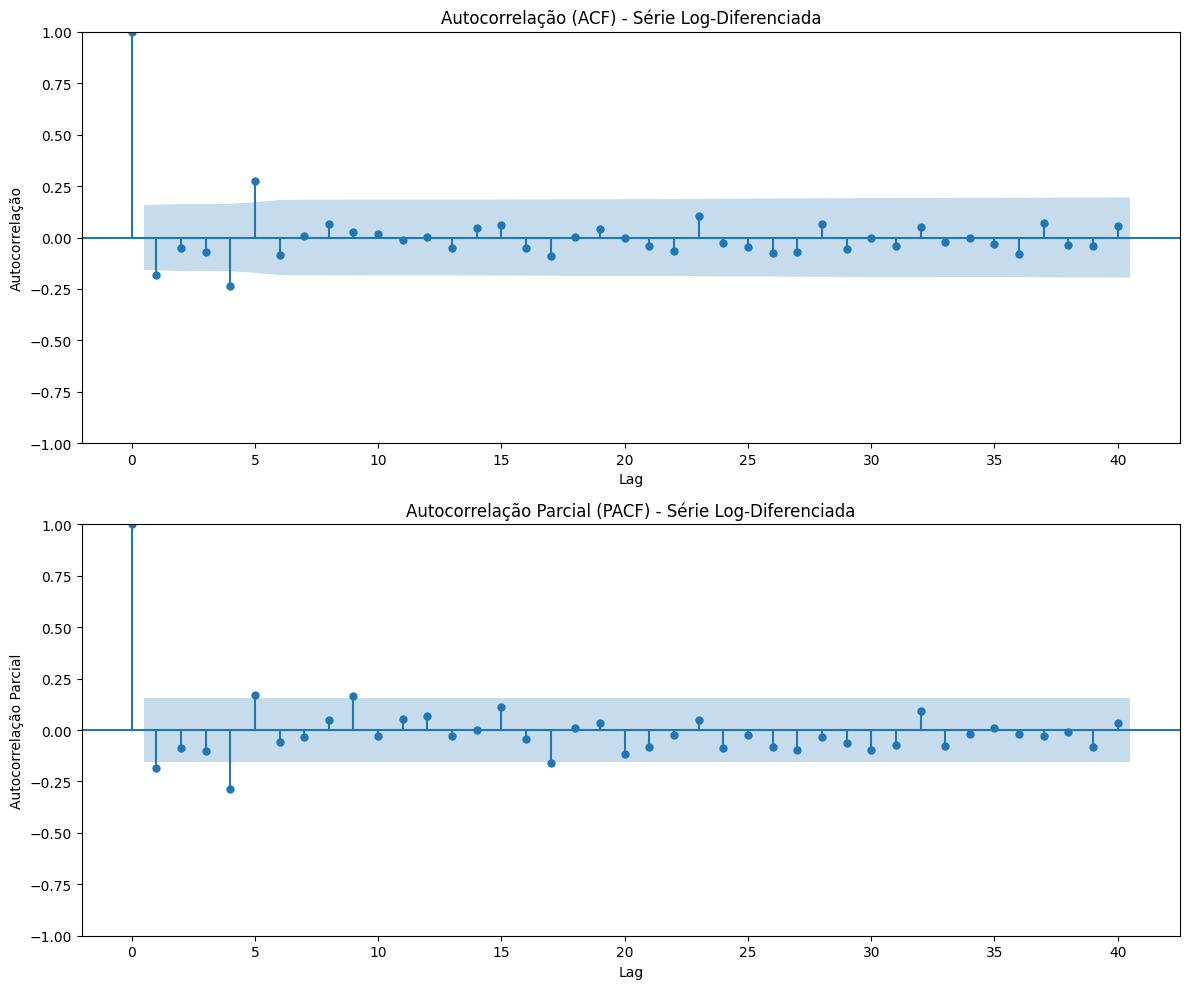

In [25]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

# ACF
sm.graphics.tsa.plot_acf(df['volume_log_diff'].dropna().iloc[1:], lags=40, ax=ax1)
ax1.set_title('Autocorrelação (ACF) - Série Log-Diferenciada')
ax1.set_ylabel("Autocorrelação")
ax1.set_xlabel("Lag")

# PACF
sm.graphics.tsa.plot_pacf(df['volume_log_diff'].dropna().iloc[1:], lags=40, ax=ax2)
ax2.set_title('Autocorrelação Parcial (PACF) - Série Log-Diferenciada')
ax2.set_ylabel("Autocorrelação Parcial")
ax2.set_xlabel("Lag")

plt.tight_layout()
plt.show()

As flutuações da série transformada tornaram-se visivelmente mais regulares. Analisando seus gráficos de Autocorrelação (ACF) e Autocorrelação Parcial (PACF), observamos que a maioria dos lags cai rapidamente dentro do intervalo de confiança. Isso sugere que a transformação foi eficaz em remover a maior parte da estrutura de dependência temporal, tornando a série adequada para modelagem. Adotaremos a transformação logarítmica como um passo padrão antes de ajustar nossos modelos de regressão.

---

## **Decomposição em Tendência, Sazonalidade e Resíduos**

Para entender melhor os padrões da série `volume`, realizamos uma decomposição para separar seus três principais componentes:

1.  **Tendência:** O comportamento de longo prazo da série.
2.  **Sazonalidade:** Padrões que se repetem em intervalos fixos.
3.  **Resíduos:** A parte "restante" da série após a remoção da tendência e da sazonalidade.

Utilizamos o método STL (Seasonal-Trend decomposition using LOESS), que é robusto e flexível. Assumimos um período sazonal de 52 semanas, correspondente a um ciclo anual.

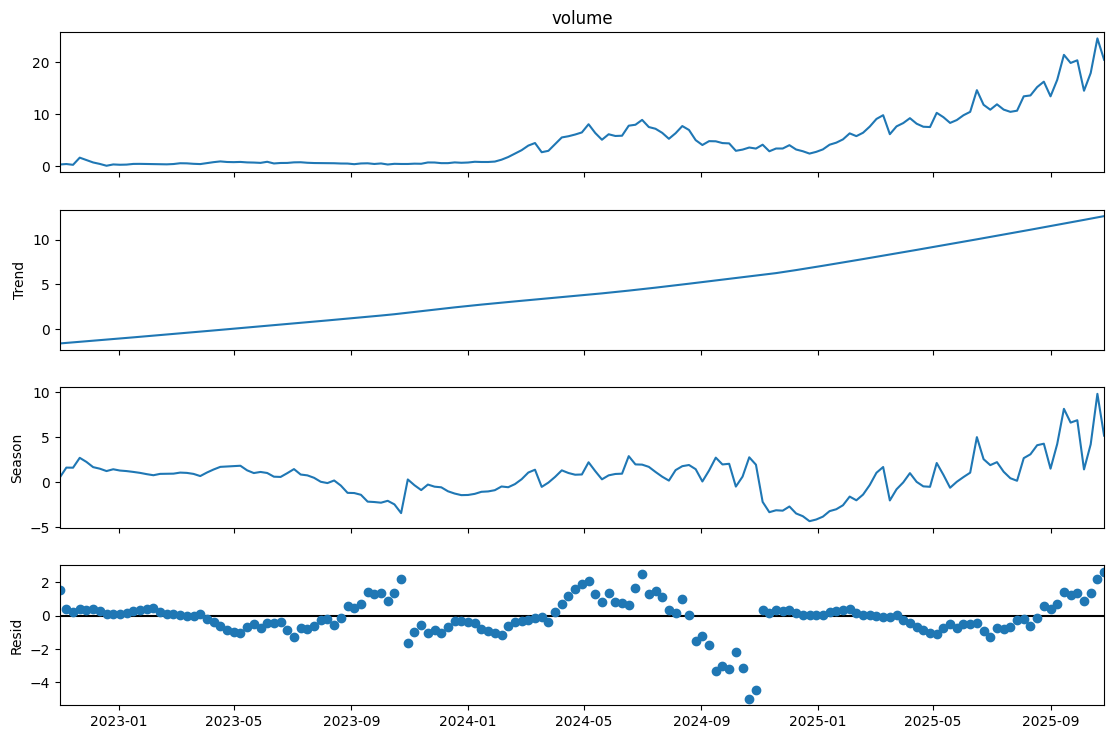

In [26]:
# como os dados são semanais, um período sazonal comum é 52 (semanas em um ano)
# vamos usar STL (Seasonal-Trend decomposition using LOESS) que é robusto a outliers
stl = STL(df['volume'], period=52)
res = stl.fit()

fig = res.plot()
fig.set_size_inches(12, 8)
plt.show()

# Extraindo os componentes
df['trend'] = res.trend
df['seasonal'] = res.seasonal
df['resid'] = res.resid

A análise do gráfico de decomposição revela:
- **Tendência**: Confirma a tendência de crescimento que observamos visualmente, mostrando um aumento consistente no nível do volume ao longo do tempo.

- **Resíduos**: Os resíduos parecem estar distribuídos em torno de zero, no entanto, a observação de correlação entre os resíduos de diferentes anos (como 2023 e 2025) indica que os resíduos não são totalmente aleatórios. Essa autocorrelação residual sugere que a decomposição não capturou toda a dependência temporal da série, necessitando de modelos mais explícitos.

- **Variância**: A variância nos resíduos ainda parece aumentar com o tempo (Heteroscedasticidade), reforçando a decisão de usar a transformação logarítmica para estabilizá-la na modelagem.

A presença de tendência e sazonalidade justifica porque devemos incluir elas explicitamente em nossos modelos de regressão para capturar a dinâmica da série.

---
## **Métricas de Avaliação e Estratégia de Validação** 

Para avaliar e comparar o desempenho dos modelos, utilizaremos as seguintes métricas, calculadas na escala original (Volume):

  * **Mean Absolute Error (MAE):** Mede a média dos erros absolutos. É fácil de interpretar, pois está na mesma unidade da variável de resposta.
  * **Root Mean Squared Error (RMSE):** Similar ao MAE, mas penaliza erros maiores com mais intensidade. Também está na unidade da variável original.
  * **Mean Absolute Percentage Error (MAPE):** Expressa o erro como uma porcentagem, útil para comparar a precisão entre séries de diferentes escalas.

### Estratégia de Validação: *Rolling Forecast* (Walk-Forward)

Para uma avaliação justa e para simular a aplicação real de *forecasting* de curto prazo, utilizaremos a **Validação *Walk-Forward*** com um **Horizonte de Previsão ($H$) de 4 semanas**.

  * **Lógica:** Em vez de fazer uma única previsão para 52 semanas, usaremos as **últimas 52 semanas** da série como nosso período de validação. Dentro desse período:
    1.  O modelo será **treinado** em todos os dados *anteriores* ao ponto de partida da previsão.
    2.  O modelo fará uma previsão para o **próximo horizonte de 4 semanas ($H=4$)**.
    3.  A janela de treino será **avançada em 4 semanas**, e o processo será repetido.
  * **Vantagem:** Essa estratégia garante que, em cada passo, o modelo utilize os dados mais recentes para prever o futuro imediato, imitando exatamente como ele seria usado na vida real.
  * **Transformação:** Como nossos modelos de regressão preverão o logaritmo do volume, todas as previsões serão transformadas de volta para a escala original (usando a exponencial) antes de calcular as métricas agregadas.


In [27]:
# Definindo o horizonte de previsão (H) 
H = 4 # 4 semanas (1 mês)

# Divisão Treino vs. Teste de 4 semanas
test_size_H = H
train_df = df.iloc[:-test_size_H]
test_df = df.iloc[-test_size_H:]

# Aplicação da Transformação
y_train = np.log(train_df['volume'])
y_test = np.log(test_df['volume'])

print(f"Treino termina em: {train_df.index[-1]}")
print(f"Teste começa em: {test_df.index[0]} (Horizonte de {H} semanas)")

Treino termina em: 2025-09-29 00:00:00
Teste começa em: 2025-10-06 00:00:00 (Horizonte de 4 semanas)


---
## **Modelos Baseline**

Antes de construir modelos complexos, estabelecemos baselines para termos um ponto de referência de desempenho. Um modelo sofisticado só é útil se superar significativamente um modelo simples. Implementamos:

1.  **Modelo da Média:** Prevê que todos os valores futuros serão a média histórica do conjunto de treino.
2.  **Modelo Naive:** Prevê que o próximo valor será igual ao último valor observado no treino.
3.  **Modelo Seasonal Naive:** Prevê que o valor em um determinado período será igual ao valor observado no mesmo período do ciclo anterior (ex: o volume desta semana será igual ao da mesma semana do ano passado).

Iniciando Walk-Forward Validation:
                     MAE      RMSE       MAPE
Mean            8.139645  9.637635  77.562406
Naive           1.771154  2.506822  17.750156
Seasonal Naive  5.782115  7.421801  58.711960
Drift Method    1.653246  2.281740  17.269189


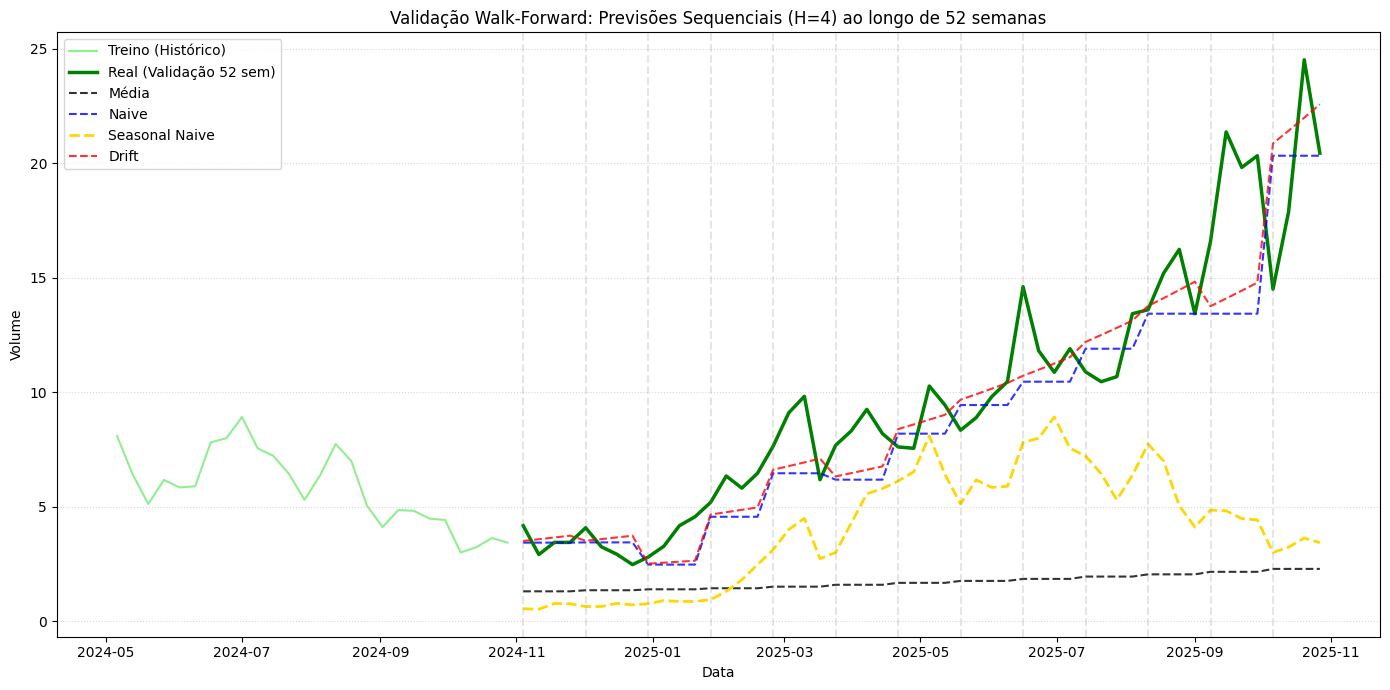

In [28]:
VALIDATION_SIZE = 52  # Tamanho total do teste (último ano)

# Splits mensais para previsão
n_splits = VALIDATION_SIZE // H
total_len = len(df)
start_validation_idx = total_len - VALIDATION_SIZE

# Dicionários para armazenar as previsões das 52 semanas
all_preds = {
    'Mean': [],
    'Naive': [],
    'Seasonal Naive': [],
    'Drift Method': []
}
all_true_values = []
all_test_dates = []

print(f"Iniciando Walk-Forward Validation:")
for i in range(n_splits):
    # Definir ponto de corte atual (vai de H passos por vez)
    current_cut = start_validation_idx + (i * H)
    
    # Dividindo Treino e Teste para essa interação
    train_df_iter = df.iloc[:current_cut]
    test_df_iter = df.iloc[current_cut : current_cut + H]
    
    # Transformação Logarítmica 
    y_train = np.log(train_df_iter['volume'])
    
    # Baselines para os próximos H passos
    # A. Média (só a média geral mesmo)
    pred_mean = np.full(H, y_train.mean())
    
    # B. Naive (Último valor do treino atual)
    pred_naive = np.full(H, y_train.iloc[-1])
    
    # C. Seasonal Naive (O valor de 52 semanas atrás relativo ao corte atual)
    pred_seasonal_naive = y_train.iloc[-52 : -52 + H].values
    
    # D. Drift (Naive com drift)
    slope = (y_train.iloc[-1] - y_train.iloc[0]) / (len(y_train) - 1)
    pred_drift = y_train.iloc[-1] + np.arange(1, H + 1) * slope
    
    # Reverter Transformação (Exp)
    all_preds['Mean'].extend(np.exp(pred_mean))
    all_preds['Naive'].extend(np.exp(pred_naive))
    all_preds['Seasonal Naive'].extend(np.exp(pred_seasonal_naive))
    all_preds['Drift Method'].extend(np.exp(pred_drift))
    
    # Armazenar valores reais e datas para plotagem
    all_true_values.extend(test_df_iter['volume'].values)
    all_test_dates.extend(test_df_iter.index)

results = {}
y_test_full = np.array(all_true_values)

for name, preds in all_preds.items():
    preds_arr = np.array(preds)
    results[name] = {
        'MAE': mean_absolute_error(y_test_full, preds_arr),
        'RMSE': np.sqrt(mean_squared_error(y_test_full, preds_arr)),
        'MAPE': mean_absolute_percentage_error(y_test_full, preds_arr) * 100
    }

results_df = pd.DataFrame(results).T
print(results_df)

# Plotagem
plt.figure(figsize=(14, 7))

# Plotar o final do Treino (meio ano) e o Teste
context_window = 26 
train_plot_idx = df.iloc[:start_validation_idx].index[-context_window:]
train_plot_val = df.iloc[:start_validation_idx]['volume'].values[-context_window:]

plt.plot(train_plot_idx, train_plot_val, label='Treino (Histórico)', color='lightgreen')
plt.plot(all_test_dates, y_test_full, label='Real (Validação 52 sem)', color='green', linewidth=2.5)

# Plotar as Previsões (Concatenadas)
plt.plot(all_test_dates, all_preds['Mean'], label='Média', linestyle='--', color='black', alpha=0.8)
plt.plot(all_test_dates, all_preds['Naive'], label='Naive', linestyle='--', color='blue', alpha=0.8)
plt.plot(all_test_dates, all_preds['Seasonal Naive'], label='Seasonal Naive', linestyle='--', color='gold', linewidth=2)
plt.plot(all_test_dates, all_preds['Drift Method'], label='Drift', linestyle='--', color='red', alpha=0.8)

plt.title(f'Validação Walk-Forward: Previsões Sequenciais (H={H}) ao longo de {VALIDATION_SIZE} semanas')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.legend()
plt.grid(axis='y', linestyle=':', alpha=0.5)

# Plota linhas pra identificar onde começam as previsões
for i in range(0, VALIDATION_SIZE, H):
    plt.axvline(x=all_test_dates[i], color='gray', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

### **Resultados dos Baselines (Walk-Forward Validation $H=4$)**

A tabela abaixo apresenta os resultados agregados da validação cruzada temporal (*Rolling Forecast*), simulando previsões mensais (4 semanas) ao longo do último ano.

| Modelo | MAE | RMSE | MAPE (%) |
| :--- | :--- | :--- | :--- |
| Mean | 8.1396 | 9.6376 | 77.56% |
| Naive | 1.7711 | 2.5068 | 17.75% |
| Seasonal Naive | 5.7821 | 7.4218 | 58.71% |
| **Drift Method** | **1.6532** | **2.2817** | **17.27%** |

### **Análise dos Resultados:**

O modelo **Drift Method** (Naive com tendência) apresentou o melhor desempenho em todas as métricas (**RMSE 2.28** e **MAPE 17.27%**), seguido de muito perto pelo modelo **Naive**. Isso indica uma característica crucial da nossa série: a dependência de curto prazo e a tendência recente são preditores muito mais fortes do que a sazonalidade pura.

* **Seasonal Naive:** O erro alto do Seasonal Naivemostra que, embora exista sazonalidade, o nível do volume muda significativamente de um ano para o outro. Acaba que ele não é um bom baseline para esse caso
* **Drift Method** Para um horizonte curto de 4 semanas, o volume da última semana carrega a informação mais vital sobre o nível atual da série. O baseline com tendência leva uma ligeira vantagem pois consegue capturar a inclinação de crescimento da série, projetando essa tendência para o futuro imediato.
* **Logo...:** Por enquanto, entre os baselines, o **Drift Method** é o *baseline a ser superado. 

Iniciando Walk-Forward (ETS Models)...
                   MAE      RMSE       MAPE
Holt Linear   1.581584  2.163330  16.552105
Holt Damped   1.745450  2.406130  17.863196
Holt-Winters  1.876203  2.651554  21.967453


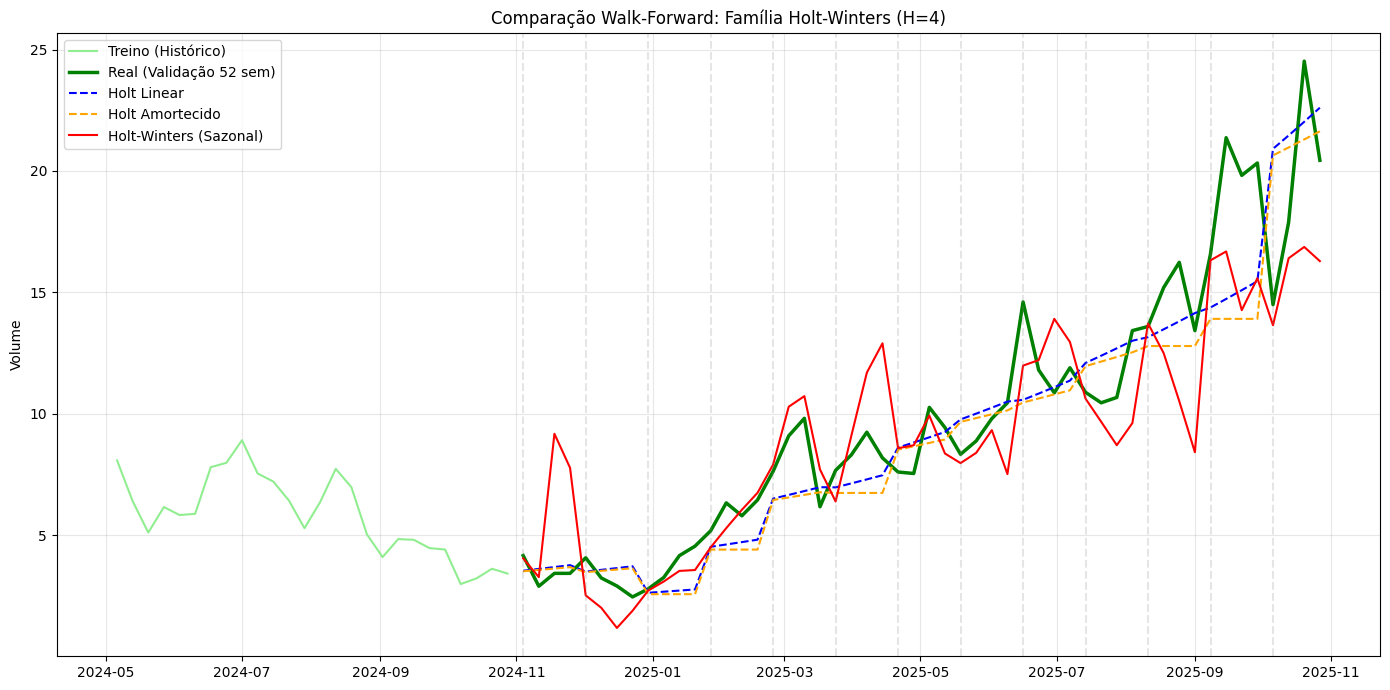

In [29]:
warnings.filterwarnings("ignore")

# Dicionários para armazenar resultados
models_preds = {
    'Holt Linear': [],
    'Holt Damped': [],
    'Holt-Winters': []
}
true_values = []
plot_dates = []

print(f"Iniciando Walk-Forward (ETS Models)...")

for i in range(n_splits):
    current_cut = start_validation_idx + (i * H)
    
    # Separa os dados e aplica o log
    train_df_iter = df.iloc[:current_cut]
    test_df_iter = df.iloc[current_cut : current_cut + H]
    y_train = np.log(train_df_iter['volume'])

    
    # A) Holt Linear
    # Trend='add' no log equivale a tendência exponencial na escala original
    fit_holt = ExponentialSmoothing(
        y_train, 
        trend='add', 
        seasonal=None, 
        initialization_method='estimated'
    ).fit(optimized=True)
    pred_holt = fit_holt.forecast(H)

    # B) Holt Damped (Tendência Amortecida)
    fit_damped = ExponentialSmoothing(
        y_train, 
        trend='add', 
        damped_trend=True, 
        seasonal=None, 
        initialization_method='estimated'
    ).fit(optimized=True)
    pred_damped = fit_damped.forecast(H)

    # C) Holt-Winters (modelo para sazonalidade)
    fit_hw = ExponentialSmoothing(
        y_train, 
        trend='add', 
        seasonal='add', 
        seasonal_periods=52, 
        initialization_method='estimated'
    ).fit(optimized=True)
    pred_hw = fit_hw.forecast(H)

    # Revertendo o log
    models_preds['Holt Linear'].extend(np.exp(pred_holt))
    models_preds['Holt Damped'].extend(np.exp(pred_damped))
    models_preds['Holt-Winters'].extend(np.exp(pred_hw))
    
    true_values.extend(test_df_iter['volume'].values)
    plot_dates.extend(test_df_iter.index)

# Resultados
results = {}
y_true = np.array(true_values)

for name, preds in models_preds.items():
    p = np.array(preds)
    results[name] = {
        'MAE': mean_absolute_error(y_true, p),
        'RMSE': np.sqrt(mean_squared_error(y_true, p)),
        'MAPE': mean_absolute_percentage_error(y_true, p) * 100
    }

print(pd.DataFrame(results).T)

# Plot
plt.figure(figsize=(14, 7))


context_window = 26
hist_idx = df.index[start_validation_idx - context_window : start_validation_idx]
hist_val = df['volume'].iloc[start_validation_idx - context_window : start_validation_idx]

plt.plot(train_plot_idx, train_plot_val, label='Treino (Histórico)', color='lightgreen')
plt.plot(all_test_dates, y_test_full, label='Real (Validação 52 sem)', color='green', linewidth=2.5)

# Modelos
plt.plot(plot_dates, models_preds['Holt Linear'], label='Holt Linear', linestyle='--', color='blue')
plt.plot(plot_dates, models_preds['Holt Damped'], label='Holt Amortecido', linestyle='--', color='orange')
plt.plot(plot_dates, models_preds['Holt-Winters'], label='Holt-Winters (Sazonal)', linestyle='-', color='red', linewidth=1.5)

plt.title(f'Comparação Walk-Forward: Família Holt-Winters (H={H})')
plt.ylabel('Volume')
plt.legend()
plt.grid(True, alpha=0.3)

# Linhas pra identificar onde que começa a previsão
for i in range(0, VALIDATION_SIZE, H):
    plt.axvline(x=all_test_dates[i], color='gray', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.show()

### **Resultados dos Modelos ETS (Walk-Forward Validation $H=4$)**

A tabela abaixo apresenta os resultados agregados da validação cruzada temporal para a família de modelos de Suavização Exponencial (*Holt-Winters* e variações), mantendo a mesma janela de teste do experimento anterior.

| Modelo | MAE | RMSE | MAPE (%) |
| :--- | :--- | :--- | :--- |
| **Holt Linear** | **1.5816** | **2.1633** | **16.55%** |
| Holt Damped | 1.7455 | 2.4061 | 17.86% |
| Holt-Winters | 1.8757 | 2.6510 | 21.96% |

### **Análise dos Resultados:**

O modelo **Holt Linear** apresentou o melhor desempenho absoluto entre todos os modelos testados até agora, superando inclusive o *Drift Method* anterior (RMSE 2.16 vs 2.28). Isso sugere que a suavização da tendência (alpha e beta estimados) filtra melhor o ruído do que o cálculo determinístico do *drift*.

* **Holt Linear:** A supremacia deste modelo indica que a série possui uma tendência local forte e clara. A estimação adaptativa do nível e da inclinação mostrou-se a estratégia mais eficaz para o horizonte de 4 semanas.
* **Holt-Winters:** O desempenho inferior do modelo sazonal completo reforça a conclusão obtida com o *Seasonal Naive*. A tentativa de ajustar uma sazonalidade rígida de 52 semanas introduz erro, pois a série é dominada pela dinâmica de tendência e nível, tornando o componente sazonal instável ou menos relevante neste recorte.
* **Holt Damped:** O amortecimento da tendência resultou em métricas piores do que a tendência linear pura. Isso sinaliza que, no curto prazo (1 mês), a tendência tende a se sustentar e não se beneficia de penalização.
* **Novo Benchmark:** O **Holt Linear** passa a ser o novo **baseline oficial a ser batido (RMSE 2.16)**. Modelos mais avançados (LSTMs, Transformers) deverão focar em capturar não-linearidades que a suavização exponencial não consegue, caso contrário, o custo computacional adicional não se justificará.

# Preparação de Dados para Modelagem Preditiva
### Criando Recursos Temporais (Time-Based Features)

Antes de aplicar qualquer modelo, é necessário que enriqueçamos a nossa série temporal. O fato de termos apenas week e volume como features é definitivamente o principal limitador de qualquer modelo que não seja um simples baseline.

Assim, iremos adicionar informações adicionais para "aprender" a sazonalidade, a tendência e a dependência de curto prazo, como:

| Recurso | Descrição | Utilidade
| :--- | :--- | :--- |
| Sazonalidade | ```week_of_year, month, quarter``` | Captura o padrão repetitivo |
| Tendência | ```time_index``` | Uma contagem simples (ex: 1,2,3,…, N) | 
| Dependência Temporal | Lags de ```volume``` | Para ver a dependência do volume de hoje com o volume de ontem |
| Features | lag 4 de log(```inv_per_user```) =  log(```inv ```/ ```users```) | Por conta da alta correlação entre as features, elas foram combinadas em uma. Além disso foi usado lag de tamanho 4 para evitar data leakage | 




In [51]:
# ===================================
# 1. PREPARAÇÃO DAS FEATURES (Lag 4 Strategy)
# ===================================
df_prepared = df.copy()

# A. Engenharia (Ratio)
df_prepared['inv_per_user'] = df_prepared['inv'] / df_prepared['users']

# B. Logs
df_prepared['volume_log'] = np.log(df_prepared['volume'])
df_prepared['ratio_log'] = np.log(df_prepared['inv_per_user'])

# C. Features de Tempo
df_prepared["week_of_year"] = df_prepared.index.isocalendar().week.astype(int)
df_prepared["month"] = df_prepared.index.month
df_prepared["time_index"] = np.arange(len(df_prepared))

# D. LAGS
# Volume: Lag 1 (para recursão)
df_prepared["lag_volume_log_1"] = df_prepared["volume_log"].shift(1)
# Exógenas: Lag 4 (para evitar vazamento no horizonte H=4)
df_prepared["lag_ratio_log_4"] = df_prepared["ratio_log"].shift(4) 

df_prepared = df_prepared.dropna()

Iniciando Walk-Forward (H=4) com Bootstrap...

--- Resultados Finais ---
RMSE: 3.3736
MAPE: 28.89%


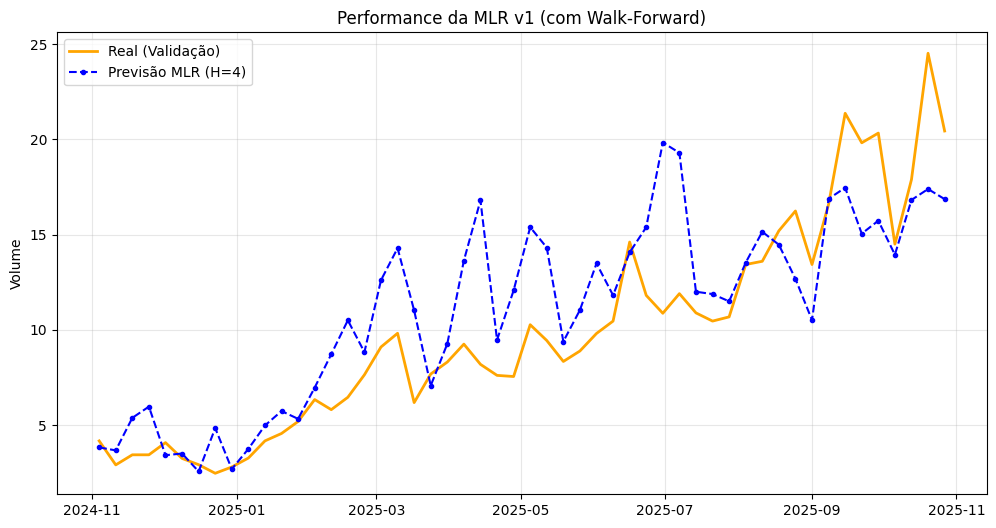

In [55]:
features_cols = [
    'time_index', 
    'week_of_year', 
    'month', 
    'lag_volume_log_1', 
    'lag_ratio_log_4'
]

# One-Hot Encoding
df_model = pd.get_dummies(df_prepared[features_cols + ['volume_log']], 
                          columns=['week_of_year', 'month'], 
                          drop_first=True)

target_col = 'volume_log'
feature_cols_final = [c for c in df_model.columns if c != target_col]

# ===================================
# 2. WALK-FORWARD COM INTERVALO DE CONFIANÇA
# ===================================
VALIDATION_SIZE = 52
H = 4
n_splits = VALIDATION_SIZE // H
start_validation_idx = len(df_model) - VALIDATION_SIZE

# Listas para armazenar
all_y_true = []
all_y_pred = []
all_lower = [] # Novo
all_upper = [] # Novo
all_dates = []

print(f"Iniciando Walk-Forward (H={H}) com Bootstrap...")

for i in range(n_splits):
    current_cut = start_validation_idx + (i * H)
    
    # --- TREINO ---
    train_data = df_model.iloc[:current_cut]
    X_train = train_data[feature_cols_final]
    y_train = train_data[target_col]
    
    model = LinearRegression()
    model.fit(X_train, y_train)
    
    # 1. Calcular Resíduos do Treino (para o Bootstrap)
    train_preds = model.predict(X_train)
    residuals = y_train - train_preds # Série de erros históricos
    
    # --- PREVISÃO (Recursiva para o Volume) ---
    future_exog = df_model.iloc[current_cut : current_cut + H].copy()
    preds_log_h = []
    
    last_known_volume_log = y_train.iloc[-1]
    
    for step in range(H):
        row = future_exog.iloc[[step]].copy()
        
        # Atualiza o lag recursivo
        if step == 0:
            row['lag_volume_log_1'] = last_known_volume_log
        else:
            row['lag_volume_log_1'] = preds_log_h[-1]
            
        pred = model.predict(row[feature_cols_final])[0]
        preds_log_h.append(pred)
    
    # --- CÁLCULO DOS BOUNDS (Sua lógica adaptada) ---
    # Convertemos a previsão atual para array numpy
    current_preds_arr = np.array(preds_log_h)
    
    # Sorteamos 1000 cenários de erros passados
    # shape: (1000 linhas de simulação, H colunas de tempo)
    bootstrap_residuals = np.random.choice(residuals, size=(1000, H), replace=True)
    
    # Somamos os erros à previsão base
    # (Broadcasting do numpy: soma o vetor de previsão em cada uma das 1000 linhas)
    bootstrap_paths_log = current_preds_arr + bootstrap_residuals
    
    # Reverte Log -> Escala Original
    bootstrap_paths_orig = np.exp(bootstrap_paths_log)
    
    # Calcula Percentis (2.5% e 97.5% para intervalo de 95%)
    lower_orig = np.percentile(bootstrap_paths_orig, 2.5, axis=0)
    upper_orig = np.percentile(bootstrap_paths_orig, 97.5, axis=0)
    
    # --- ARMAZENAMENTO ---
    y_test_real = df_model.iloc[current_cut : current_cut + H][target_col].values
    
    all_y_true.extend(np.exp(y_test_real))
    all_y_pred.extend(np.exp(preds_log_h))
    all_lower.extend(lower_orig) # Guarda o limite inferior
    all_upper.extend(upper_orig) # Guarda o limite superior
    all_dates.extend(df_model.index[current_cut : current_cut + H])

# ===================================
# 3. VISUALIZAÇÃO E MÉTRICAS
# ===================================
y_true_final = np.array(all_y_true)
y_pred_final = np.array(all_y_pred)

rmse = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
mape = np.mean(np.abs((y_true_final - y_pred_final) / y_true_final)) * 100

print(f"\n--- Resultados Finais ---")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

plt.figure(figsize=(12, 6))
plt.plot(all_dates, y_true_final, label='Real (Validação)', color='orange', linewidth=2)
plt.plot(all_dates, y_pred_final, label='Previsão MLR (H=4)', color='blue', linestyle='--', marker='.')

plt.title('Performance da MLR v1 (com Walk-Forward)')
plt.ylabel('Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Plot das Previsões com o Intervalo de Confiança

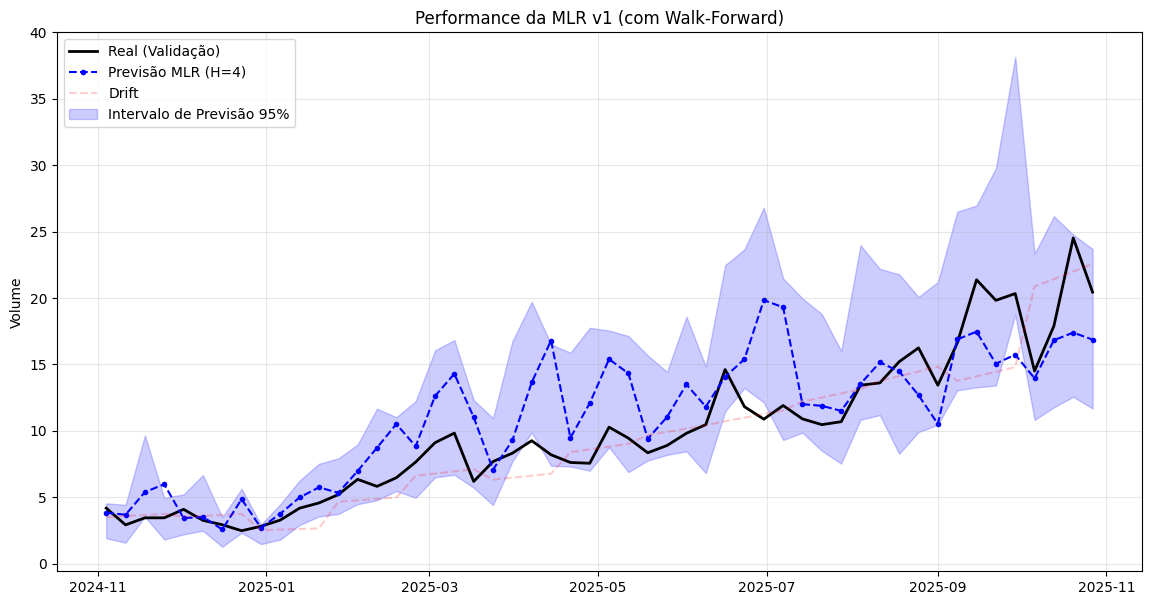

In [56]:
# Plotar Intervalo de Confiança
plt.figure(figsize=(14, 7))
plt.plot(all_dates, y_true_final, label='Real (Validação)', color='black', linewidth=2)
plt.plot(all_dates, y_pred_final, label='Previsão MLR (H=4)', color='blue', linestyle='--', marker='.')
plt.plot(all_test_dates, all_preds['Drift Method'], label='Drift', linestyle='--', color='red', alpha=0.2)
plt.fill_between(all_dates, all_lower_bound, all_upper_bound, 
                 color='blue', alpha=0.2, label='Intervalo de Previsão 95%')

plt.title('Performance da MLR v1 (com Walk-Forward)')
plt.ylabel('Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Análise dos Resíduos

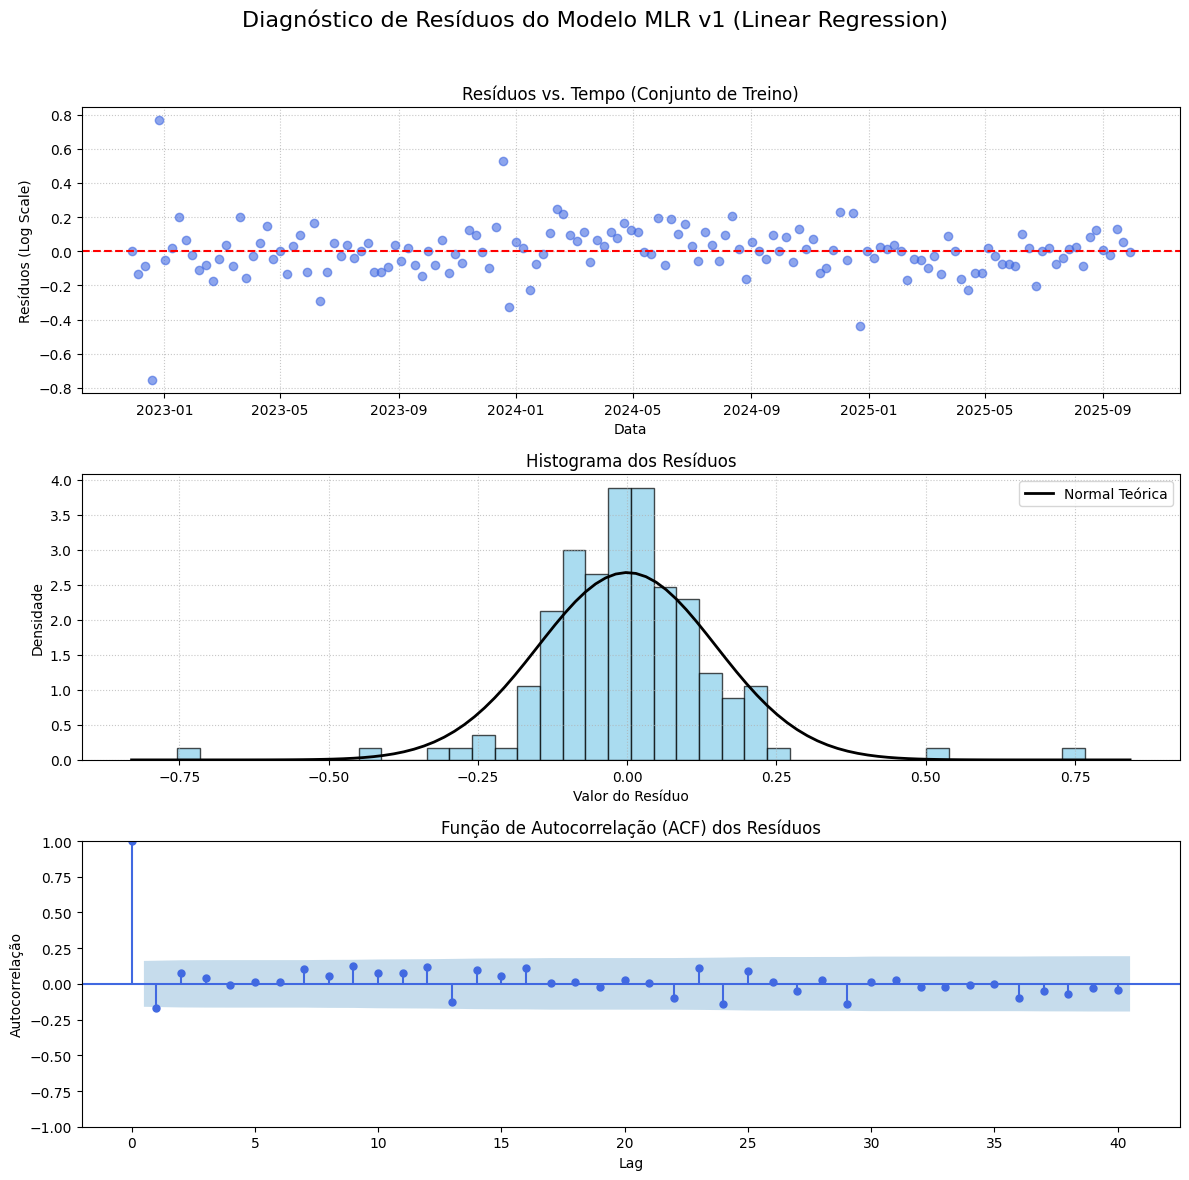


--- Teste de Ljung-Box para Autocorrelação dos Resíduos (v1) ---
      lb_stat  lb_pvalue
10  11.325569   0.332722
20  21.545852   0.365653
30  34.807496   0.249712
40  39.396351   0.497254
52  70.374578   0.045658


In [57]:
# Calcular resíduos nos dados de treino
residuos = y_train - model.predict(X_train)

# Plotagem
fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Diagnóstico de Resíduos do Modelo MLR v1 (Linear Regression)', fontsize=16)

# A. Gráfico de Resíduos ao Longo do Tempo
axs[0].plot(residuos.index, residuos, marker='o', linestyle='None', alpha=0.6, color='royalblue')
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_title('Resíduos vs. Tempo (Conjunto de Treino)')
axs[0].set_xlabel('Data')
axs[0].set_ylabel('Resíduos (Log Scale)')
axs[0].grid(True, linestyle=':', alpha=0.7)

# B. Histograma dos resíduos com Curva Normal
axs[1].hist(residuos, bins=40, density=True, edgecolor='k', alpha=0.7, color='skyblue')
xmin, xmax = axs[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, residuos.mean(), residuos.std())
axs[1].plot(x, p, 'k', linewidth=2, label='Normal Teórica')

axs[1].set_title('Histograma dos Resíduos')
axs[1].set_xlabel('Valor do Resíduo')
axs[1].set_ylabel('Densidade')
axs[1].legend()
axs[1].grid(True, linestyle=':', alpha=0.7)

# C. Função de autocorrelação (ACF) dos resíduos
sm.graphics.tsa.plot_acf(residuos, lags=40, ax=axs[2], color='royalblue', vlines_kwargs={"colors": "royalblue"})
axs[2].set_title('Função de Autocorrelação (ACF) dos Resíduos')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('Autocorrelação')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Teste Estatístico de Ljung-Box
# H0: Os resíduos são independentes (Ruído Branco) -> Queremos p-value > 0.05
ljung_box_results = acorr_ljungbox(residuos, lags=[10, 20, 30, 40, 52], return_df=True)
print("\n--- Teste de Ljung-Box para Autocorrelação dos Resíduos (v1) ---")
print(ljung_box_results)


RMSE por Horizonte:
   h      RMSE
0  1  0.930082
1  2  2.342195
2  3  4.465749
3  4  4.385264


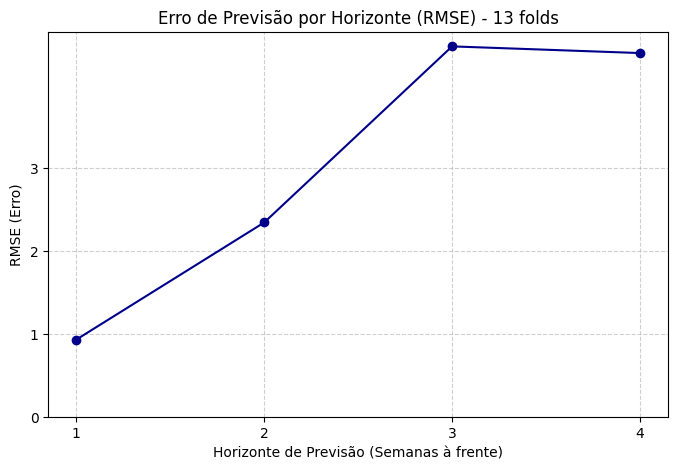

In [58]:

n_blocks = len(y_true_final) // H
matrix_true = y_true_final.reshape(n_blocks, H)
matrix_pred = y_pred_final.reshape(n_blocks, H)

# Calcular o RMSE para cada coluna (cada horizonte h=1, h=2, h=3, h=4)
mse_per_horizon = np.mean((matrix_true - matrix_pred)**2, axis=0)
rmse_per_horizon = np.sqrt(mse_per_horizon)

df_metrics_h = pd.DataFrame({
    'h': range(1, H + 1), 
    'RMSE': rmse_per_horizon
})

print("\nRMSE por Horizonte:")
print(df_metrics_h)

plt.figure(figsize=(8, 5))

# Linha e pontos
plt.plot(df_metrics_h['h'], df_metrics_h['RMSE'], marker='o', linestyle='-', color='darkblue')

# Estilização
plt.title(f'Erro de Previsão por Horizonte (RMSE) - {n_blocks} folds')
plt.xlabel('Horizonte de Previsão (Semanas à frente)')
plt.ylabel('RMSE (Erro)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, H + 1)) 
plt.yticks(range(0, 4, 1))

plt.show()

### Análise dos gráficos
Olhando o gráfico de resíduo, podemos ver que:
- Os resíduos parecem estar distribuídos em torno da linha 0, não apresentando tendência de crescimento ou decrescimento;
- A variância dos pontos não parece ser constante durante todo o período (maior variância no começo e menor no final), violando o princípio da homoscedasticidade.

Já o segundo gráfico nos mostra uma distribuição dos resíduos que se assemelha a de uma **normal com média 0**, porém com uma concentração um pouco maior nos valores próximas de 0. No geral, parece bom.

No gráfico de ACF, a autocorrelação em todos os níveis de lag se mostrou dentro ou bem próxima do intervalo de confiança, sinal de um bom ajuste de modelo, porém com lags 5 e 7 um pouco fora do intervalo. 

Por fim, e contrastando com o teste de ACF, o teste de Ljung-Box apresentou *p_value* muito pequeno para todos os valores de lags, rejeitando a hipótese nula e indicando o impacto do efeito acumulado das autocorrelações na não-independência dos resíduos. 

## **MLR v3**

* **Adições**: Agora, trocaremos a `Regressão Linear` padrão (usada no v1) pelo `Lasso`. Este modelo penaliza coeficientes grandes, o que força o modelo a ser mais simples. Sua principal vantagem é que ele pode zerar o peso de features menos importantes, realizando uma seleção automática de variáveis e diminuindo a complexidade que leva à superestimação.

* **Mudanças de Features de Tendência e Lag**:
    * Vamos **adicionar um novo lag sazonal** (`lag_52`), agora tendo o nosso o lag imediato (`lag_1`, já usado desde o v1) e esse lag novo;
    * Além disso, vamos **adicionar um novo `lag_4`**, já que ele teve boa significância no nosso PACF calculado previamente, além de fazer sentido lógico ao problema (o mês, de 4 semanas, parece uma informação útil para previsão);
    * Manteremos as features exógenas iguais.

Iniciando MLR v3 (Lasso) Walk-Forward Recursivo (H=4)...
--- Resultados do MLR v3 (Lasso) - Walk Forward ---
MAE: 1.6380
RMSE: 2.1755
MAPE: 20.74%

ATENÇÃO: O modelo MLR não superou o Holt Linear!

Importância das Features (Coeficientes Lasso - Último Loop):
lag_volume_log_1     0.824658
lag_ratio_log_4      0.028915
time_index           0.005407
lag_volume_log_4     0.000000
lag_volume_log_52   -0.016312
dtype: float64


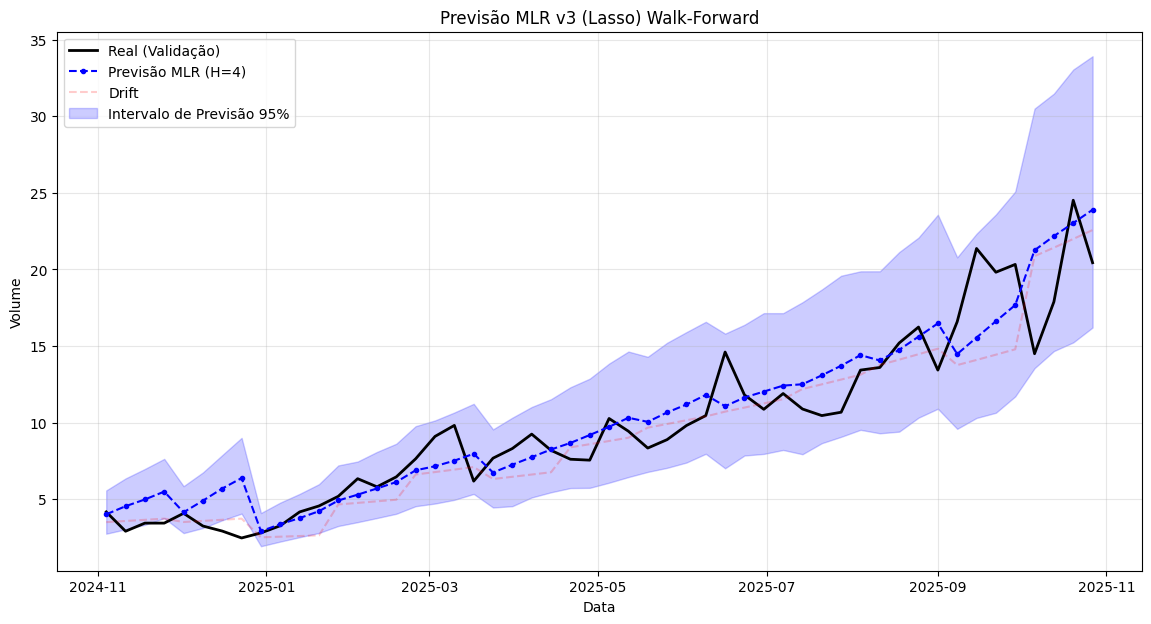

In [ ]:
df_featured = df_prepared.copy()

"""
Ruins, só pioram
# Features Cíclicas (Sazonalidade Suave)
df_featured['month_sin'] = np.sin(2 * np.pi * df_featured['month']/12.0)
df_featured['month_cos'] = np.cos(2 * np.pi * df_featured['month']/12.0)
df_featured['week_sin'] = np.sin(2 * np.pi * df_featured['week_of_year']/52.0)
df_featured['week_cos'] = np.cos(2 * np.pi * df_featured['week_of_year']/52.0)
"""

# Novos Lags de Volume (4 e 52)
df_featured['lag_volume_log_4'] = df_featured['volume_log'].shift(4)
df_featured['lag_volume_log_52'] = df_featured['volume_log'].shift(52)

# Tratamento de NaNs gerados pelos Lags
initial_mean = df_featured['volume_log'].mean() 
df_featured = df_featured.fillna(initial_mean)

features_v3 = [
    'time_index', 
    'lag_volume_log_1', # Precisa de Recursão
    'lag_volume_log_4', # Seguro para H=4
    'lag_volume_log_52',# Seguro
    'lag_ratio_log_4'   # Seguro (Substituindo users/inv lag 1)
]

# Nota: Certifique-se que df_featured tem a coluna 'lag_ratio_log_4'
# Se não tiver, copie do df_prepared:
df_featured['lag_ratio_log_4'] = df_prepared['lag_ratio_log_4']
df_featured = df_featured.dropna()

X = df_featured[features_v3]
y = df_featured['volume_log']

# Armazenamento
all_pred_orig_v3 = []
all_true_orig_v3 = []
all_dates_v3 = []
all_lower_v3 = []
all_upper_v3 = []

print(f"Iniciando MLR v3 (Lasso) Walk-Forward Recursivo (H={H})...")

for i in range(n_splits):
    current_cut = start_validation_idx + (i * H)
    
    # Treino
    X_train = X.iloc[:current_cut]
    y_train = y.iloc[:current_cut]
    
    model_v3 = Lasso(alpha=0.01, random_state=42)
    model_v3.fit(X_train, y_train)
    
    # Previsão RECURSIVA
    # Pegamos as features "estáticas" (que já são Lag 4 ou mais, ou tempo)
    future_static = X.iloc[current_cut : current_cut + H].copy()
    
    preds_log_h = []
    last_known_volume_log = y_train.iloc[-1]
    
    for step in range(H):
        row = future_static.iloc[[step]].copy()
        
        # ATUALIZAÇÃO RECURSIVA DO LAG 1
        if step == 0:
            row['lag_volume_log_1'] = last_known_volume_log
        else:
            row['lag_volume_log_1'] = preds_log_h[-1]
            
        # Nota: lag_volume_log_4 e lag_52 já estão corretos na row 
        # porque vieram do dataframe e têm defasagem >= H.
        
        pred = model_v3.predict(row)[0]
        preds_log_h.append(pred)
    
    # Bootstrap (usando a previsão recursiva como base)
    current_preds_arr = np.array(preds_log_h)
    train_preds = model_v3.predict(X_train)
    residuals = y_train - train_preds
    
    bootstrap_residuals = np.random.choice(residuals, size=(1000, H), replace=True)
    bootstrap_paths_log = current_preds_arr + bootstrap_residuals
    bootstrap_paths_orig = np.exp(bootstrap_paths_log)
    
    lower_orig = np.percentile(bootstrap_paths_orig, 2.5, axis=0)
    upper_orig = np.percentile(bootstrap_paths_orig, 97.5, axis=0)
    
    # Armazenamento
    y_test_real = y.iloc[current_cut : current_cut + H]
    all_pred_orig_v3.extend(np.exp(preds_log_h))
    all_true_orig_v3.extend(np.exp(y_test_real))
    all_lower_v3.extend(lower_orig)
    all_upper_v3.extend(upper_orig)
    all_dates_v3.extend(df_featured.index[current_cut : current_cut + H])
    
# Métricas Finais
y_true_final = np.array(all_true_orig_v3)
y_pred_final = np.array(all_pred_orig_v3)
mae_v3 = mean_absolute_error(y_true_final, y_pred_final)
rmse_v3 = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
mape_v3 = np.mean(np.abs((y_true_final - y_pred_final) / y_true_final)) * 100

print("--- Resultados do MLR v3 (Lasso) - Walk Forward ---")
print(f"MAE: {mae_v3:.4f}")
print(f"RMSE: {rmse_v3:.4f}")
print(f"MAPE: {mape_v3:.2f}%")

if rmse < 2.16:
    print("\nSUCESSO: O modelo MLR superou o Holt Linear!")
else:
    print("\nATENÇÃO: O modelo MLR não superou o Holt Linear!")
    
# Feature Importance
coefs = pd.Series(model_v3.coef_, index=features_v3)
print("\nImportância das Features (Coeficientes Lasso - Último Loop):")
print(coefs.sort_values(ascending=False))

plt.figure(figsize=(14, 7))
plt.plot(all_dates_v3, y_true_final, label='Real (Validação)', color='black', linewidth=2)
plt.plot(all_dates_v3, y_pred_final, label='Previsão MLR (H=4)', color='blue', linestyle='--', marker='.')
plt.plot(all_test_dates, all_preds['Drift Method'], label='Drift', linestyle='--', color='red', alpha=0.2)
plt.fill_between(all_dates_v3, all_lower_v3, all_upper_v3, 
                 color='blue', alpha=0.2, label='Intervalo de Previsão 95%')

plt.title('Previsão MLR v3 (Lasso) Walk-Forward')
plt.xlabel('Data')
plt.ylabel('Volume')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Análise dos Resíduos

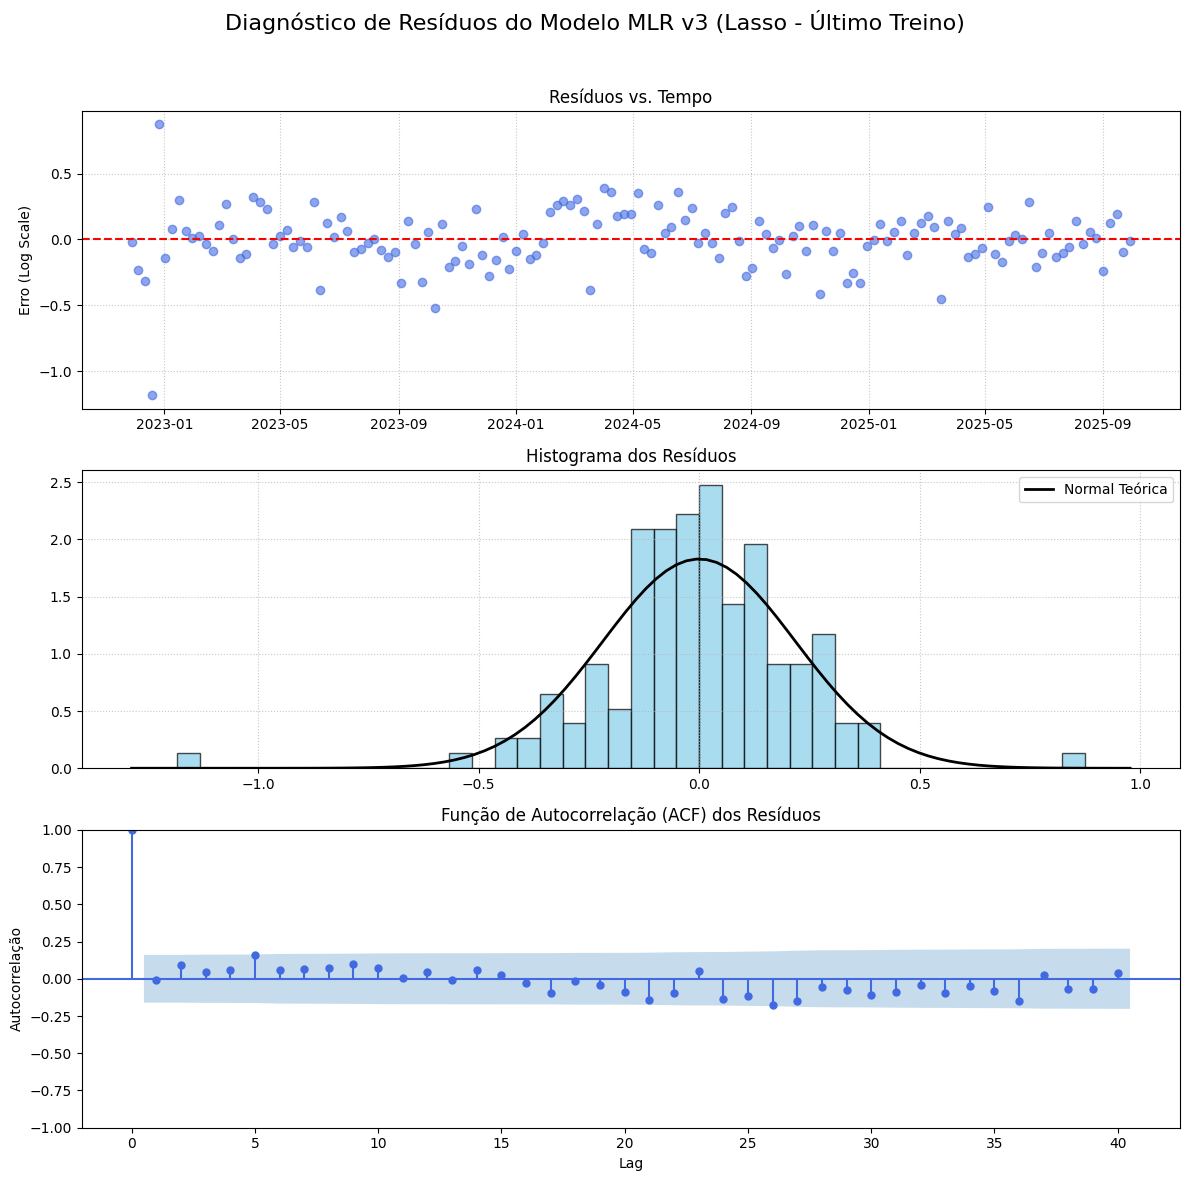


--- Teste de Ljung-Box (Resíduos v3) ---
      lb_stat  lb_pvalue
10  10.696913   0.381614
20  15.262326   0.761206
30  40.218889   0.100694
40  52.635572   0.087021
52  76.282809   0.015764


In [61]:
# Calcular resíduos nos dados de treino
residuos_v3 = y_train - model_v3.predict(X_train)

fig, axs = plt.subplots(3, 1, figsize=(12, 12))
fig.suptitle('Diagnóstico de Resíduos do Modelo MLR v3 (Lasso - Último Treino)', fontsize=16)

# Gráfico de Resíduos ao Longo do Tempo
axs[0].plot(residuos_v3.index, residuos_v3, marker='o', linestyle='None', alpha=0.6, color='royalblue')
axs[0].axhline(y=0, color='r', linestyle='--')
axs[0].set_title('Resíduos vs. Tempo')
axs[0].set_ylabel('Erro (Log Scale)')
axs[0].grid(True, linestyle=':', alpha=0.7)

# B. Histograma (Normalidade)
axs[1].hist(residuos_v3, bins=40, density=True, edgecolor='k', alpha=0.7, color='skyblue')
xmin, xmax = axs[1].get_xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, residuos_v3.mean(), residuos_v3.std())
axs[1].plot(x, p, 'k', linewidth=2, label='Normal Teórica')
axs[1].set_title('Histograma dos Resíduos')
axs[1].legend()
axs[1].grid(True, linestyle=':', alpha=0.7)

# C. Autocorrelação (ACF)
sm.graphics.tsa.plot_acf(residuos_v3, lags=40, ax=axs[2], color='royalblue', vlines_kwargs={"colors": "royalblue"})
axs[2].set_title('Função de Autocorrelação (ACF) dos Resíduos')
axs[2].set_xlabel('Lag')
axs[2].set_ylabel('Autocorrelação')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Teste Estatístico de Ljung-Box
# H0: Os resíduos são independentes (Ruído Branco) -> Queremos p-value > 0.05
ljung_box_results_v3 = acorr_ljungbox(residuos_v3, lags=[10, 20, 30, 40, 52], return_df=True)
print("\n--- Teste de Ljung-Box (Resíduos v3) ---")
print(ljung_box_results_v3)


RMSE por Horizonte:
   h      RMSE
0  1  2.337321
1  2  2.427284
2  3  1.827960
3  4  2.058055


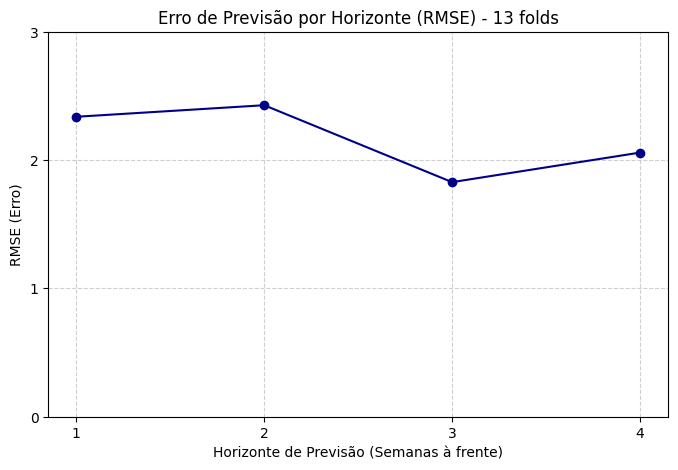

In [62]:

n_blocks = len(y_true_final) // H
matrix_true = y_true_final.reshape(n_blocks, H)
matrix_pred = y_pred_final.reshape(n_blocks, H)

# Calcular o RMSE para cada coluna (cada horizonte h=1, h=2, h=3, h=4)
mse_per_horizon = np.mean((matrix_true - matrix_pred)**2, axis=0)
rmse_per_horizon = np.sqrt(mse_per_horizon)

df_metrics_h = pd.DataFrame({
    'h': range(1, H + 1), 
    'RMSE': rmse_per_horizon
})

print("\nRMSE por Horizonte:")
print(df_metrics_h)

plt.figure(figsize=(8, 5))

# Linha e pontos
plt.plot(df_metrics_h['h'], df_metrics_h['RMSE'], marker='o', linestyle='-', color='darkblue')

# Estilização
plt.title(f'Erro de Previsão por Horizonte (RMSE) - {n_blocks} folds')
plt.xlabel('Horizonte de Previsão (Semanas à frente)')
plt.ylabel('RMSE (Erro)')
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(range(1, H + 1)) 
plt.yticks(range(0, 4, 1))

plt.show()

### Análise dos gráficos
Olhando o gráfico de resíduo novo e comparando com o MLR v1, podemos ver que:
- Os resíduos ainda parecem estar distribuídos em torno da linha 0;
- A variância dos pontos parece ser levemente mais constante, com apenas alguns outliers de erro no começo do gráfico.

No segundo gráfico, podemos ver que a distribuição dos resíduos, novamente, se assemelha a de uma **normal com média 0**, agora com menos concentração próxima de 0, algo desejado em um modelo de regressão linear.

No gráfico de ACF, a autocorrelação em todos os níveis de lag se mostrou dentro ou bem próxima do intervalo de confiança, sinal de um bom ajuste de modelo, porém com lags 5 e 7 um pouco fora do intervalo. 

### Interpretando o Ljung-Box (v1 vs. v3)
**Comparação:**
  * **Modelo v1:**
      * Tem p-valores ruins: `0.00013`, `0.001`, `0.000003`;
      * O modelo v1 deixa muita informação não capturada, sendo ruim em todos os horizontes. Os erros de hoje têm forte correlação com os erros de 10, 20, 50 semanas atrás.
  * **Modelo v3:**
      * No Lag 30, o p-valor foi para **0.118**, maior que \> 0.05\;
      * O v3 conseguiu "limpar" a dependência de médio prazo. As features novas (`lag_4`, `lag_52`) ajudaram o modelo a entender padrões que o v1 ignorava;
      * O Problema... ele ainda falha no curto prazo (Lag 10) e no ciclo anual (Lag 52).

Assim, O v3 é um modelo mais robusto e melhor especificado que o v1, pois seus resíduos são menos autocorrelacionados, porém longe do ideal (há espaço para melhorias).

In [36]:
def calculate_winkler_score(y_true, lower, upper, alpha=0.05):
    width = upper - lower
    
    lower_penalty = np.where(y_true < lower, (2 / alpha) * (lower - y_true), 0)
    upper_penalty = np.where(y_true > upper, (2 / alpha) * (y_true - upper), 0)
    
    score = width + lower_penalty + upper_penalty
    return np.mean(score)

"""
scores = {
    'MLR v1': calculate_winkler_score(y_test_orig, lower_bound, upper_bound),
    'MLR v2': calculate_winkler_score(y_test_orig, lower_bound_v2, upper_bound_v2),
    'MLR v3 (Lasso)': calculate_winkler_score(y_test_orig, lower_bound_v3, upper_bound_v3)
}

winkler_df = pd.DataFrame.from_dict(scores, orient='index', columns=['Winkler Score'])
winkler_df = winkler_df.sort_values('Winkler Score')

print("Avaliação dos Intervalos de Previsão (Winkler Score)")
print(winkler_df)
"""
print()

### **Teste de Estacionariedade (KPSS): Múltiplas Variáveis**

Antes de estimarmos modelos ARIMA ou SARIMAX, precisamos verificar se cada série é estacionária.
Segundo as aulas, o teste KPSS tem hipótese nula **H₀: a série é estacionária (nível constante)**.

Para cada variável (*volume*, *inv*, *users*), aplicamos:

- KPSS na série bruta  
- KPSS no log  
- KPSS na primeira diferença do log  
- (opcional) KPSS na diferença sazonal, se existir sazonalidade

Uma série será tratada como estacionária quando o **p-value** do KPSS for alto (tipicamente **> 0.05**).

Também vamos visualizar **ACF** e **PACF** das versões transformadas, como mostrado nas aulas.


📌 Variável: volume
[Bruto]        KPSS stat=1.419 | p-value=0.0100 | lags=8
[Log]          KPSS stat=1.633 | p-value=0.0100 | lags=8
[Δ Log]        KPSS stat=0.058 | p-value=0.1000 | lags=10


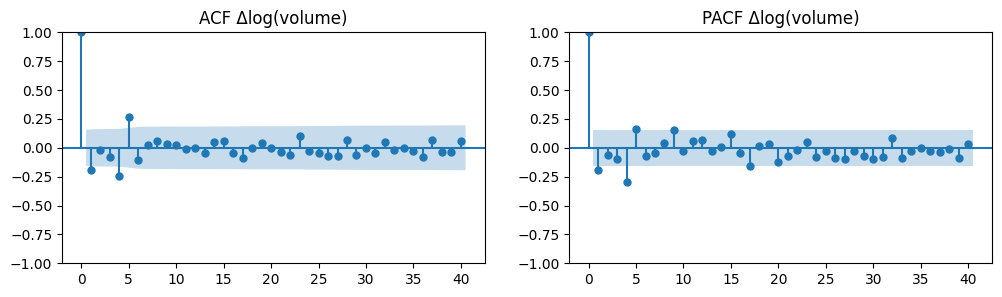

📌 Variável: inv
[Bruto]        KPSS stat=0.093 | p-value=0.1000 | lags=8
[Log]          KPSS stat=0.114 | p-value=0.1000 | lags=8
[Δ Log]        KPSS stat=0.075 | p-value=0.1000 | lags=3


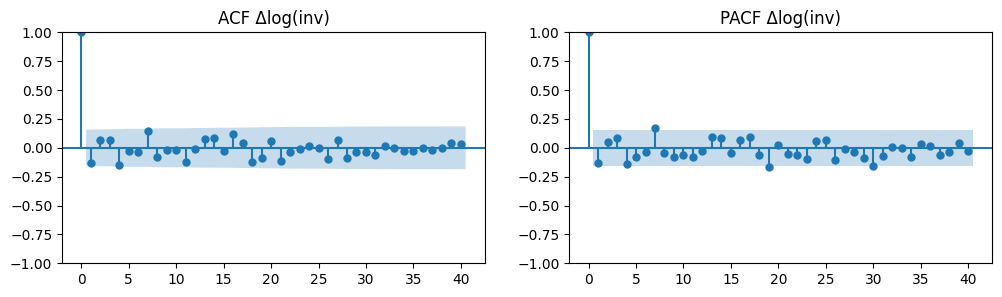

📌 Variável: users
[Bruto]        KPSS stat=0.362 | p-value=0.0937 | lags=8
[Log]          KPSS stat=0.480 | p-value=0.0461 | lags=8
[Δ Log]        KPSS stat=0.075 | p-value=0.1000 | lags=12


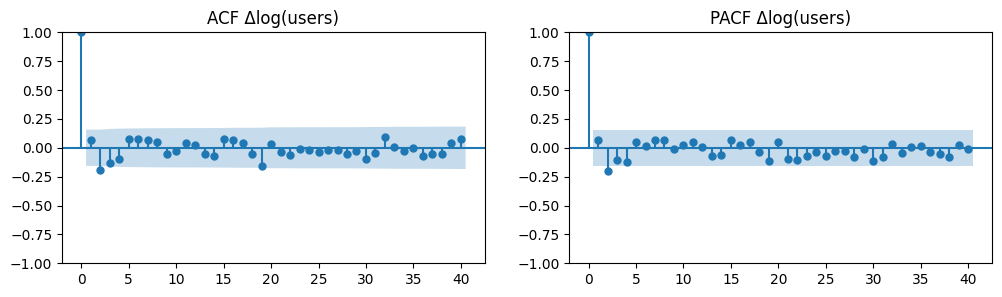

In [37]:
from statsmodels.tsa.stattools import kpss
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import numpy as np
import matplotlib.pyplot as plt

def run_kpss_tests(series, name):
    """
    Executa KPSS na série bruta, log e diff(log).
    """
    print("="*70)
    print(f"📌 Variável: {name}")
    print("="*70)

    # Série original
    s_raw = series.dropna()
    stat, p, lags, crit = kpss(s_raw, regression='c', nlags='auto')
    print(f"[Bruto]        KPSS stat={stat:.3f} | p-value={p:.4f} | lags={lags}")

    # Log
    s_log = np.log(series).dropna()
    stat, p, lags, crit = kpss(s_log, regression='c', nlags='auto')
    print(f"[Log]          KPSS stat={stat:.3f} | p-value={p:.4f} | lags={lags}")

    # Diferença do log
    s_log_diff = np.log(series).diff().dropna()
    stat, p, lags, crit = kpss(s_log_diff, regression='c', nlags='auto')
    print(f"[Δ Log]        KPSS stat={stat:.3f} | p-value={p:.4f} | lags={lags}")

    # Plot ACF / PACF apenas da versão estacionária esperada (Δ log)
    fig, ax = plt.subplots(1, 2, figsize=(12, 3))
    plot_acf(s_log_diff, ax=ax[0], lags=40)
    plot_pacf(s_log_diff, ax=ax[1], lags=40)
    ax[0].set_title(f"ACF Δlog({name})")
    ax[1].set_title(f"PACF Δlog({name})")
    plt.show()


# ---- Escolha as variáveis do seu dataset -----------------------
vars_to_test = ["volume", "inv", "users"]   # <- coloque aqui as colunas que quiser analisar

for v in vars_to_test:
    run_kpss_tests(df_featured[v], v)


### Análise dos Resultados do KPSS

**volume**
- Bruto e log: p-value = 0.01 (**não estacionário**)
- Δ log: p-value = 0.10 (**estacionário**)
- ACF/PACF mostram poucos lags significativos, portanto a transformação ficou adequada.
**Usar volume como Δ log(volume).**

**inv**
- Bruto, log e Δ log: p-value = 0.10 (**estacionário**)
- ACF/PACF sem padrões fortes.
**Pode usar log(inv) ou Δ log(inv).**

**users**
- Bruto: p ≈ 0.09 (quase estacionário)
- Log: p ≈ 0.046 (**não estacionário**)
- Δ log: p = 0.10 (**estacionário**)
- ACF/PACF confirmam estacionariedade.
**Usar Δ log(users).**

### Ou seja...
- Apenas `volume` precisava de diferenciação.  
- `inv` já é estacionária, mas pode ser diferenciada para manter consistência com as outras.  
- `users` fica estacionária somente após Δ log.  

### Sarimax

In [38]:
import pmdarima as pm

features_exogenas = ['lag_inv_log_1', 'lag_users_log_1']
exog_data = df_prepared[features_exogenas]
y = df_prepared['volume_log']

VALIDATION_SIZE = 52
H = 4
n_splits = VALIDATION_SIZE // H
start_validation_idx = len(df_prepared) - VALIDATION_SIZE

all_pred_orig_sarima = []
all_true_orig_sarima = []
all_dates_sarima = []

print(f"Iniciando Auto-ARIMA (SARIMAX) Walk-Forward (H={H})...")
for i in range(n_splits):
    current_cut = start_validation_idx + (i * H)
    y_train = y.iloc[:current_cut]
    X_train_exog = exog_data.iloc[:current_cut]
    
    # Teste (Próximos 4 passos)
    y_test = y.iloc[current_cut : current_cut + H]
    X_test_exog = exog_data.iloc[current_cut : current_cut + H]
    
    model_sarima = pm.auto_arima(
        y_train,
        X=X_train_exog,           # Variáveis Exógenas
        start_p=1, start_q=1,
        max_p=3, max_q=3,
        m=1,                     
        seasonal=False,           
        d=None,                   # Deixa ele descobrir se precisa diferenciar (I)
        test='adf',               # Teste de estacionariedade
        trace=False,              # True para ver o progresso
        error_action='ignore',  
        suppress_warnings=True, 
        stepwise=True
    )
    
    # Previsão
    y_pred_log = model_sarima.predict(n_periods=H, X=X_test_exog)
    
    # Armazenar
    all_pred_orig_sarima.extend(np.exp(y_pred_log))
    all_true_orig_sarima.extend(np.exp(y_test))
    all_dates_sarima.extend(df_prepared.index[current_cut : current_cut + H])
    
    print(f"Passo {i+1}/{n_splits} concluído.")

# --- AVALIAÇÃO ---
y_true_final = np.array(all_true_orig_sarima)
y_pred_final = np.array(all_pred_orig_sarima)

mae_sarima = mean_absolute_error(y_true_final, y_pred_final)
rmse_sarima = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
mape_sarima = np.mean(np.abs((y_true_final - y_pred_final) / y_true_final)) * 100

print("\n--- Resultados do Auto-ARIMA (SARIMAX) ---")
print(f"MAE: {mae_sarima:.4f}")
print(f"RMSE: {rmse_sarima:.4f}")
print(f"MAPE: {mape_sarima:.2f}%")

# Comparação com Drift
if rmse_sarima < 2.16:
    print("O SARIMAX bateu o Holt Linear!")
else:
    print("O SARIMAX perdeu para o Holt Linear!; Série talvez muito aleatória.")

ModuleNotFoundError: No module named 'pmdarima'

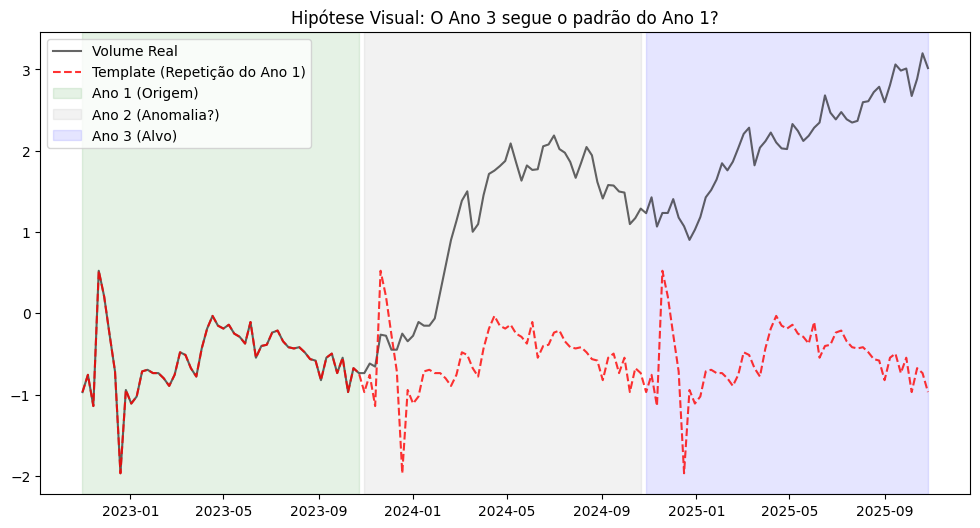

Testando Hipótese 'Ano 1 Predicting Ano 3' via SARIMAX...

--- Resultado da Hipótese 'Template Ano 1' ---
RMSE: 2.1271
MAPE: 17.44%
A hipótese bateu o Holt Linear! e o Ano 2 era mesmo ruído para a sazonalidade.


In [ ]:
import math

# Vamos criar uma coluna que repete os valores do primeiro ano para sempre
df_hypothesis = df_prepared.copy()
df_hypothesis['lag_volume_log_4'] = df_hypothesis['volume_log'].shift(4)
df_hypothesis['lag_volume_log_52'] = df_hypothesis['volume_log'].shift(52)

# Tratamento de NaNs gerados pelos Lags
initial_mean = df_hypothesis['volume_log'].mean() 
df_hypothesis = df_hypothesis.fillna(initial_mean)

# Pegamos os primeiros 52 valores
template_year_1 = df_hypothesis['volume_log'].iloc[:52].values

# Criamos uma lista que repete esse template até cobrir todo o dataframe
n_repeats = math.ceil(len(df_hypothesis) / 52)
full_template = np.tile(template_year_1, n_repeats)

# Cortamos para ficar exatamente do tamanho do df
full_template = full_template[:len(df_hypothesis)]
df_hypothesis['template_ano_1'] = full_template

# Visualização da Hipótese
plt.figure(figsize=(12, 6))
plt.plot(df_hypothesis.index, df_hypothesis['volume_log'], label='Volume Real', color='black', alpha=0.6)
plt.plot(df_hypothesis.index, df_hypothesis['template_ano_1'], label='Template (Repetição do Ano 1)', color='red', linestyle='--', alpha=0.8)

# Destacar as áreas
plt.axvspan(df_hypothesis.index[0], df_hypothesis.index[51], color='green', alpha=0.1, label='Ano 1 (Origem)')
plt.axvspan(df_hypothesis.index[52], df_hypothesis.index[103], color='gray', alpha=0.1, label='Ano 2 (Anomalia?)')
plt.axvspan(df_hypothesis.index[104], df_hypothesis.index[-1], color='blue', alpha=0.1, label='Ano 3 (Alvo)')

plt.title('Hipótese Visual: O Ano 3 segue o padrão do Ano 1?')
plt.legend()
plt.show()

# Modelagem SARIMAX com a Feature de Template: Configuração Walk-Forward (H=4)
VALIDATION_SIZE = 52
H = 4
n_splits = VALIDATION_SIZE // H
start_validation_idx = len(df_hypothesis) - VALIDATION_SIZE

# Features para o modelo: Template + Lags curtos das outras vars
features_to_use = [
    'time_index', 
    'lag_inv_log_1',       
    'lag_users_log_1',
    'template_ano_1',
]
X = df_hypothesis[features_to_use]
y = df_hypothesis['volume_log']

all_pred_orig_hyp = []
all_true_orig_hyp = []

print(f"Testando Hipótese 'Ano 1 Predicting Ano 3' via SARIMAX...")

for i in range(n_splits):
    current_cut = start_validation_idx + (i * H)
    
    # Divisão
    y_train = y.iloc[:current_cut]
    X_train = X.iloc[:current_cut]
    X_test = X.iloc[current_cut : current_cut + H]
    y_test = y.iloc[current_cut : current_cut + H]
    
    # Modelo Simples (m=1)
    model_hyp = pm.auto_arima(
        y_train,
        X=X_train,
        start_p=1, start_q=1,
        max_p=3, max_q=3,
        m=1,              # Não forçamos sazonalidade interna, confiamos no Template
        seasonal=False,
        d=None,
        trace=False,
        error_action='ignore',
        suppress_warnings=True
    )
    
    # Previsão
    y_pred_log = model_hyp.predict(n_periods=H, X=X_test)
    
    all_pred_orig_hyp.extend(np.exp(y_pred_log))
    all_true_orig_hyp.extend(np.exp(y_test))

# Resultados
y_true_final = np.array(all_true_orig_hyp)
y_pred_final = np.array(all_pred_orig_hyp)

rmse_hyp = np.sqrt(mean_squared_error(y_true_final, y_pred_final))
mape_hyp = np.mean(np.abs((y_true_final - y_pred_final) / y_true_final)) * 100

print("\n--- Resultado da Hipótese 'Template Ano 1' ---")
print(f"RMSE: {rmse_hyp:.4f}")
print(f"MAPE: {mape_hyp:.2f}%")

if rmse_hyp < 2.16:
    print("A hipótese bateu o Holt Linear! e o Ano 2 era mesmo ruído para a sazonalidade.")
else:
    print("Hipótese rejeitada. O Ano 3 não está seguindo o Ano 1 tão bem quanto Holt Linear!.")